# **Forecasting Realized Volatility**

In contrast to *implied volatility* (IV), which reflects the market’s expectation of future uncertainty, *realized volatility* (RV) corresponds to the volatility that actually materializes over a given horizon. From a modeling perspective, RV exhibits strong persistence and clustering, making it more forecastable than IV or returns themselves.

## Why Forecast Realized Volatility?

Forecasting RV is valuable for several reasons in both trading and risk management:

- **Volatility Trading & IV–RV Strategies**  
  Accurate RV forecasts allow us to identify mispricings between implied and realized volatility. For example, if IV is significantly higher than the forecasted RV, it may indicate an opportunity to short volatility and harvest the volatility risk premium (VRP).

- **Position Sizing**  
  Forecasted volatility can be used to dynamically scale positions: larger sizes in calm regimes, smaller sizes in volatile markets.  

- **Risk Management (Stop Loss / Take Profit)**  
  RV forecasts help set realistic expectations for daily or monthly moves, which can inform stop-loss and take-profit levels in directional strategies.


## Research Questions
- Can we extend the HAR-RV model with extensions (HAR-RV-VIX) to forecast teh forward 21-day realieed variance whihc is boht econcomiacally intepretable andparsimonious ? 
- Can Random Forest model can capture non-linearity and intercaction effetcs between the predictors in a useful way ?
- If so, can we construct a model (either linear HAR-RV-X or non linear RF or an ensemble of both) that can beat HAR-RV and Naive RV benchmarks ? 

The purpose of this notebook is to forecast the 21-D realized volatility using HAR-RV and Random Forest ML models. 
For that we explore different family of predictors where some of them are heavily documented (like HAR-RV lags or VIX) while some of them not (macro and market predictors). For that we use several feature importance techniques to decide whihc features to put in parsimonious Linear models and more exotic Random Forest model.


## Summary

The notebook is structured as follows:

1. [Read & Prepare Data](#read_data)
2. [Volatility Estimators](#real-vol)
   - [2.1. Historical (close-to-close): 10D, 21D, 100D](#trade-execution-setup)
   - [2.2. Range-based (OHLC): Parkinson, GK, Rogers-Satchel, Yang Zhang](#trade-execution-setup)
   - [2.3. High-Frequency Estimators: Realized Variance](#e)
3. [Stylized facts of realized volatility](#real-vol)
4. [Problem Formualation]()
   - [5.1 Target Variable: 21-Day Realized Variance](#trade-execution-setup)
   - [5.1 Predictors of realized volatility](#trade-execution-setup)
5. [Feature Engineering: Rolling and regime-switching features](#real-vol)
6. [Data-Preprocessing: Data transformation, scaling and redundent features removal](#real-vol)
6. [Methodology: Model Specification, cross-validaiton, evaluation metrics](#real-vol)
7. [Feature Importance and Stability Analysis](#real-vol)
7. [Model Selection: Linear vs Random Forest](#real-vol)
9. [Evaluation: Walk forward with cross val, RMSE vs QLIKE, plotting residuals, refitting models every months](#real-vol)

In [1]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from matplotlib import gridspec
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score

import volatility_trading.rv_forecasting.features as rvfeat
import volatility_trading.rv_forecasting.vol_estimators as rvvol
import volatility_trading.rv_forecasting.plotting as ph

from volatility_trading.iv_surface.ssvi_model import SSVI
from volatility_trading.rv_forecasting.data_loading import load_intraday_prices
from volatility_trading.rv_forecasting.modelling import (
    WalkForwardOOS, DataProcessor, PurgedKFold, compute_metrics,
    in_sample_stability, single_feature_importance, oos_perm_importance,
    eval_model_cv, eval_ensembles
)

np.random.seed(42)
random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

pd.options.mode.chained_assignment = None 

# **1. Read & Prepare Data**

For this analysis we are going to consider daily S&P500 OHLC data from Yahoo finance for a research period from `2010` to `2020`. The last years of data from `2021` to late `2025` will be imported at the end for the backtest so that we don't introduce a look ahead bais in our results.

In [2]:
start = "2010-01-01"
end = "2020-12-31"

spx = yf.download("^GSPC", start=start, end=end, auto_adjust=True)
spx.columns = spx.columns.droplevel("Ticker")
spx.columns.name = None
spx

[*********************100%***********************]  1 of 1 completed


Close         High          Low         Open      Volume
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000
...                 ...          ...          ...          ...         ...
2020-12-23  3690.010010  3711.239990  3689.280029  3693.419922  3779160000
2020-12-24  3703.060059  3703.820068  3689.320068  3694.030029  1883780000
2020-12-28  3735.360107  3740.510010  3723.030029  3723.030029  3535460000
2020-12-29  3727.040039  3756.120117  3723.310059  3750.010010  3393290000
2020-12-30  3732.040039  3744.629883  3730.209961  3736.189941  3154850000

[2768 rows x 5 columns]

In [3]:
spx.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [4]:
spx["returns"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx = spx.dropna()
spx

Close         High          Low         Open      Volume  \
Date                                                                         
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000   
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000   
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000   
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000   
2010-01-11  1146.979980  1149.739990  1142.020020  1145.959961  4255780000   
...                 ...          ...          ...          ...         ...   
2020-12-23  3690.010010  3711.239990  3689.280029  3693.419922  3779160000   
2020-12-24  3703.060059  3703.820068  3689.320068  3694.030029  1883780000   
2020-12-28  3735.360107  3740.510010  3723.030029  3723.030029  3535460000   
2020-12-29  3727.040039  3756.120117  3723.310059  3750.010010  3393290000   
2020-12-30  3732.040039  3744.629883  3730.209961  3736.189941  3154850000   

             returns  
Date                  
2010-01-05  0.003111  
2010-01-06  0.000545  
2010-01-07  0.003993  
2010-01-08  0.002878  
2010-01-11  0.001745  
...              ...  
2020-12-23  0.000746  
2020-12-24  0.003530  
2020-12-28  0.008685  
2020-12-29 -0.002230  
2020-12-30  0.001341  

[2767 rows x 6 columns]

Text(0.5, 1.0, 'Log Returns')

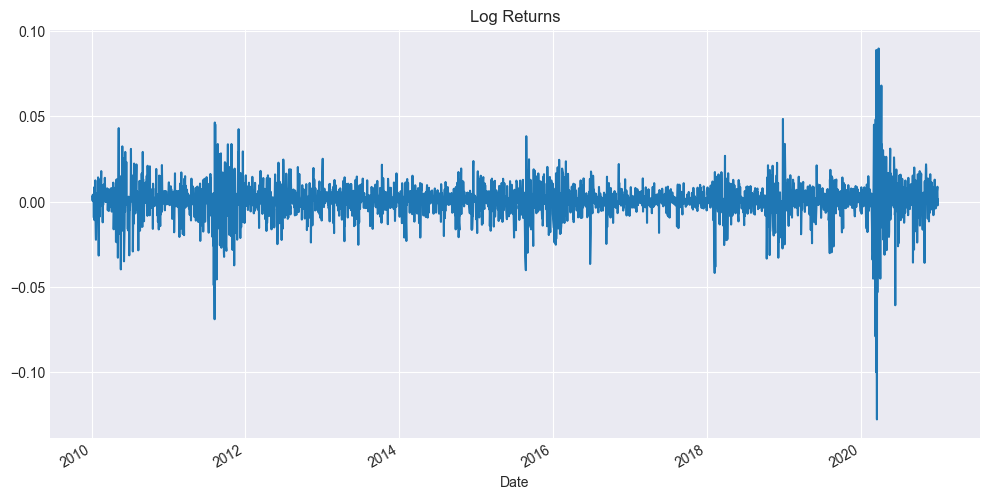

In [5]:
spx["returns"].plot(figsize=(12, 6))
plt.title("Log Returns")

# **2. Volatility Estimators**

Volatility is a *latent* quantity — it cannot be observed directly. To evaluate forecasts and build predictors, we need to construct **proxies** from price data. Different estimators trade off bias vs efficiency depending on the sampling frequency and data available.

## 2.1 Historical / Close-to-Close

The simplest approach uses only closing price data and is often called the **close-to-close estimator**.   It computes realized volatility from consecutive daily returns. This estimator serves as a useful **benchmark**, but it suffers from several drawbacks: it ignores intraday variation, overnight jumps, and the information contained in opening, high, and low prices, which often makes it downward biased.

Formally, over a horizon $H$:

$$
RV_{t,H} = \sqrt{\tfrac{252}{H} \sum_{j=1}^H r_{t+j}^2}, 
\quad r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

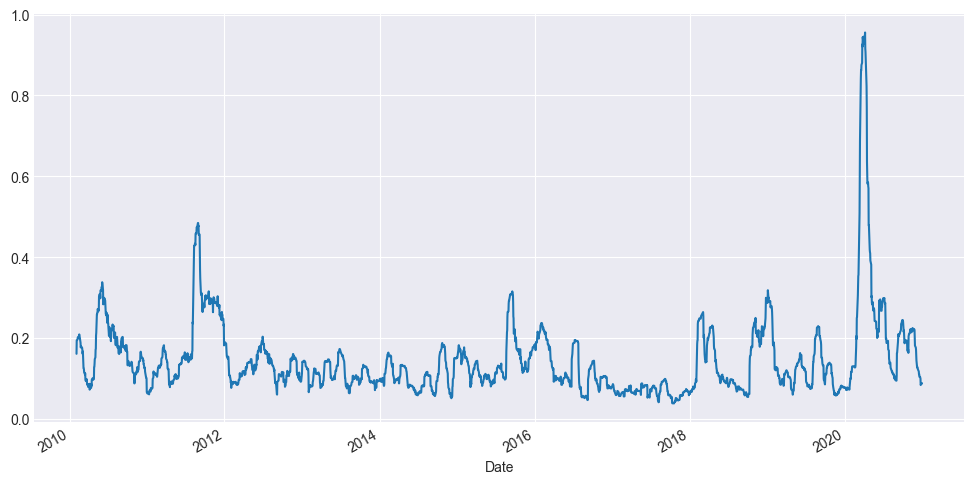

In [6]:
spx["rv_close"] = rvvol.rv_close_to_close(spx["returns"], h=21)
spx["rv_close"].plot(figsize=(12, 6))
plt.show()


## 2.2 Range-Based Proxies (OHLC)

Instead of using only daily closing prices, we can exploit the full **Open–High–Low–Close (OHLC)** information to build more efficient volatility estimators.
Over time, several **range-based measures** have been proposed, each improving on the simple close-to-close estimator in different ways.

These estimators:
- typically **reduce the variance** of the volatility estimate,
- better capture **intraday price dynamics**,
- but rely on specific modelling assumptions (e.g. no drift, no jumps) and each has its own limitations.

In this section we review a few standard OHLC-based proxies and compare them to the close-to-close benchmark.

### 2.2.1 Parkinson Estimator

The **Parkinson (1980) estimator** uses the daily high–low range to capture intraday price variability.  
By relying on the full range rather than just closing prices, it provides a more efficient estimate of volatility under the assumption of a **driftless geometric Brownian motion**.  

However, it ignores opening and closing prices and is highly sensitive to jumps or bid–ask bounce at the extremes of the trading day.

Formally, over a horizon $H$:

$$
RV^{\text{Parkinson}}_{t,H} 
= \sqrt{ \frac{252}{4H \ln(2)} \sum_{j=1}^H \left[ \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right]^2 }
$$

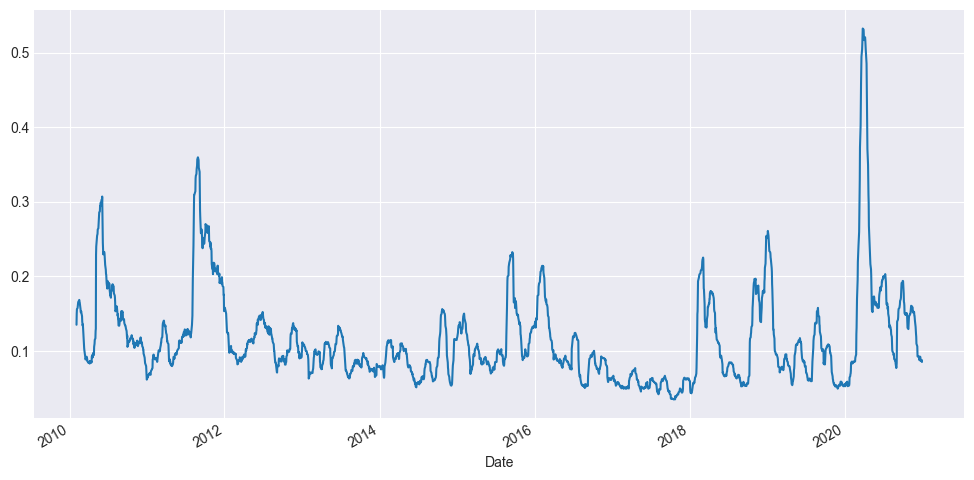

In [7]:
spx["rv_parkinson"] = rvvol.rv_parkinson(spx["High"], spx["Low"], h=21)
spx["rv_parkinson"].plot(figsize=(12, 6))
plt.show()

### 2.2.2 Garman–Klass Estimator

The **Garman–Klass (1980) estimator** improves upon the Parkinson measure by incorporating not only the daily high and low, but also the open and close prices.  
This allows it to capture more information about intraday price variation and reduce estimation variance under the assumption of a driftless geometric Brownian motion.  

However, like the Parkinson estimator, it can be biased in the presence of significant drift or opening jumps, since it assumes zero drift and continuous trading.

Formally, over a horizon $H$:

$$
RV^{\text{GK}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ \tfrac{1}{2} \left( \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right)^2 
- (2\ln(2) - 1) \left( \ln\!\left(\tfrac{C_{t+j}}{O_{t+j}}\right) \right)^2 
\right] }
$$

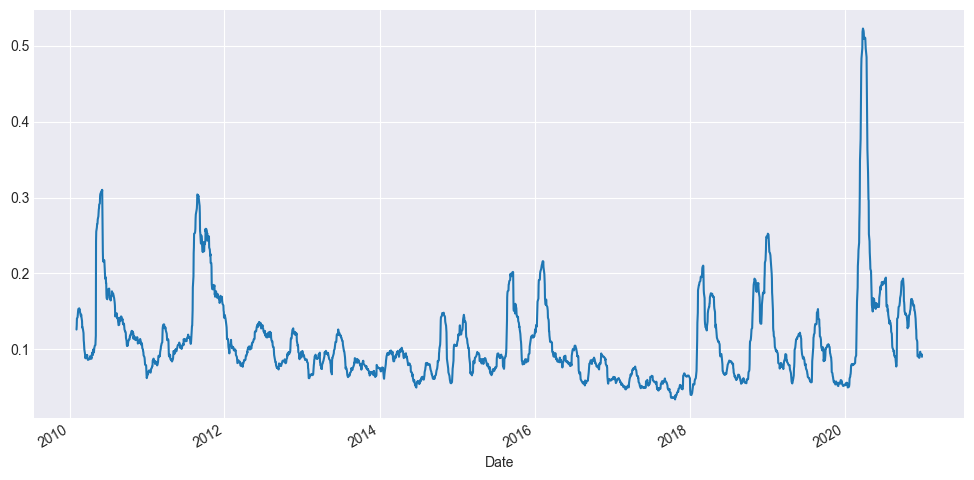

In [8]:
spx["rv_gk"] = rvvol.rv_garman_klass(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_gk"].plot(figsize=(12, 6))
plt.show()

### 2.2.3 Rogers–Satchell Estimator

The Rogers–Satchell (1991) estimator was introduced to fix a key limitation of the Parkinson and Garman–Klass estimators: their assumption of **zero drift**. Unlike those, Rogers–Satchell is **drift-robust**, making it more suitable for assets that can trend over time.

It still uses all four **OHLC** prices, but in a different functional form that explicitly allows for **nonzero expected returns**. However, like other OHLC-based estimators, it remains **sensitive to microstructure noise** and **large jumps** at the open or close.

Formally, over a horizon $H$:

$$
RV^{\text{RS}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ 
\ln\!\left(\tfrac{H_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{H_{t+j}}{O_{t+j}}\right) 
+ \ln\!\left(\tfrac{L_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{L_{t+j}}{O_{t+j}}\right) 
\right] }
$$

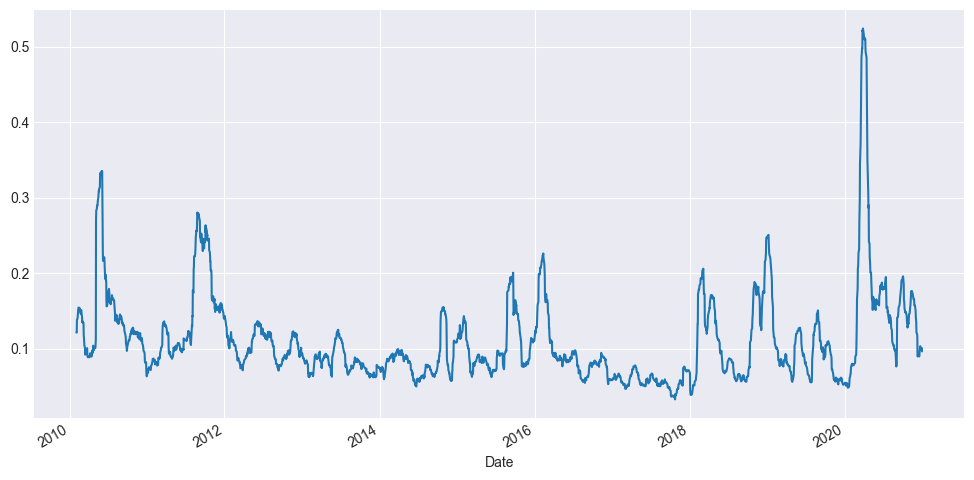

In [9]:
spx["rv_rs"] = rvvol.rv_rogers_satchell(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_rs"].plot(figsize=(12, 6))
plt.show()

### 2.2.4 Yang–Zhang Estimator

The **Yang–Zhang (2000) estimator** combines the advantages of previous methods by incorporating overnight variance, open-to-close variance, and the Rogers–Satchell range-based component.  
It is **unbiased in the presence of drift**, less sensitive to opening jumps, and has significantly lower estimation variance compared to Parkinson, Garman–Klass, or Rogers–Satchell taken alone.  

This makes Yang–Zhang one of the most efficient daily volatility estimators available when OHLC data are present.

Formally, the daily Yang–Zhang variance can be expressed as:

$$
\sigma^2_{YZ} = \sigma^2_O + k \, \sigma^2_C + (1-k)\, \sigma^2_{RS}
$$

where  
- $\sigma^2_O = \big( \ln(O_t / C_{t-1}) \big)^2$ is the overnight variance,  
- $\sigma^2_C = \big( \ln(C_t / O_t) \big)^2$ is the open-to-close variance,  
- $\sigma^2_{RS}$ is the Rogers–Satchell variance component,  
- $k \approx 0.34$ is a weight chosen to minimize bias and variance.  

Aggregating over a horizon $H$:

$$
RV^{\text{YZ}}_{t,H} = \sqrt{ \frac{252}{H} \sum_{j=1}^H \sigma^2_{YZ,\,t+j} }
$$

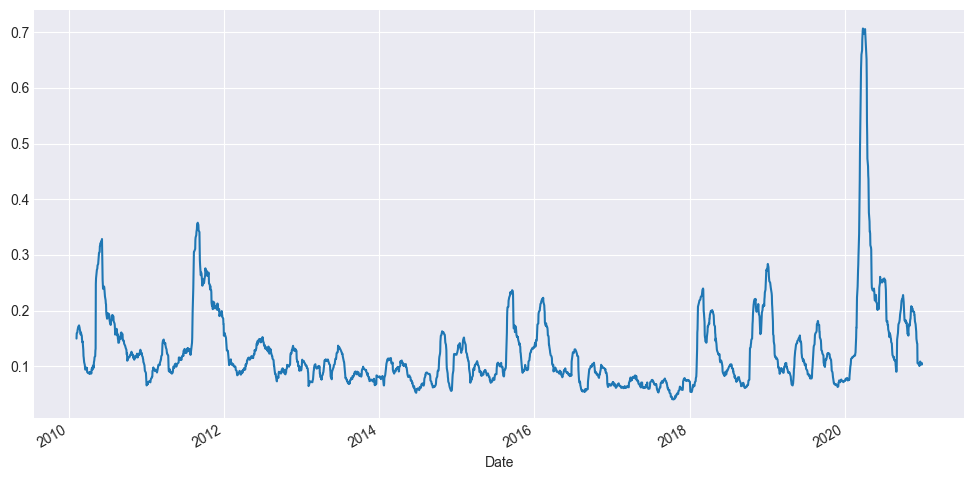

In [10]:
spx["rv_yz"] = rvvol.rv_yang_zhang(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_yz"].plot(figsize=(12, 6))
plt.show()

## 2.3 Which Estimator to choose ?

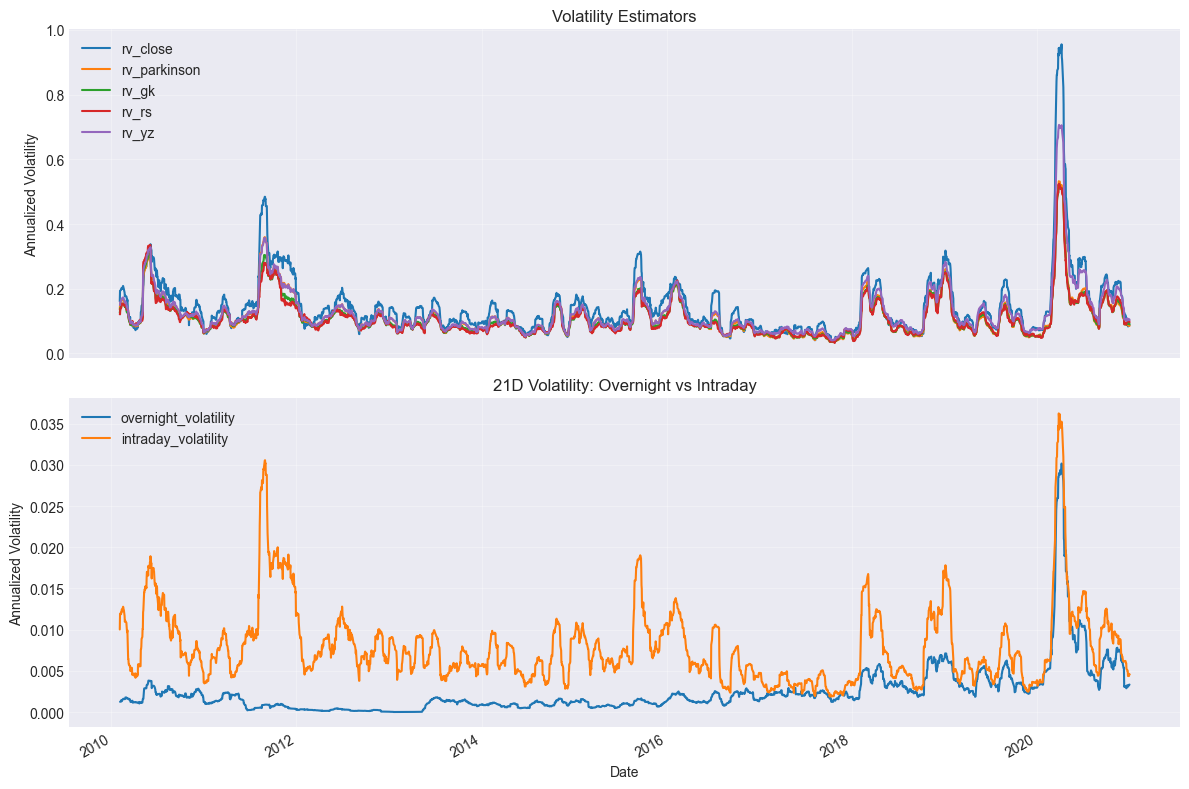

In [11]:
spx["overnight_volatility"] = np.log(spx["Open"] / spx["Close"].shift(1)).rolling(21).std()
spx["intraday_volatility"] = np.log(spx["Close"] / spx["Open"]).rolling(21).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- top panel: volatility estimators ---
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax1)
ax1.set_title("Volatility Estimators")
ax1.set_ylabel("Annualized Volatility")
ax1.grid(alpha=0.3)
ax1.legend()

# --- bottom panel: overnight vs intraday volatility ---
spx[["overnight_volatility", "intraday_volatility"]].plot(ax=ax2)
ax2.set_title("21D Volatility: Overnight vs Intraday")
ax2.set_ylabel("Annualized Volatility")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

- **Insight:** You’ll see that in stress regimes (e.g., 2008, COVID-19 crash), *overnight moves dominate*. YZ explicitly accounts for this.

### 2.3 High-Frequency Estimators: Realized Variance

With **5-minute high-frequency data**, we can incorporate much more intraday information than when relying only on daily OHLC data.  
In this notebook, we use **E-mini S&P 500 futures (ES)**, which trade almost 24 hours a day, so the realized measure naturally includes overnight returns as well.  

The choice of a 5-minute sampling grid is widely recognized as the best trade-off between capturing information and avoiding microstructure distortions: it explains about **90–95% of daily integrated variance**. At higher frequencies (e.g., 1-min, tick), **microstructure noise**—such as bid–ask bounce and discrete price jumps—becomes more prominent, requiring more advanced techniques (e.g., **pre-averaged RV** or **realized kernels**).  

As a baseline, we consider the **realized variance (RV)** estimator, defined over a day $t$ with intraday returns $r_{t,i}$ as:

$$
RV_t = \sum_{i=1}^{N_t} r_{t,i}^2,
\quad 
r_{t,i} = \ln\!\left(\frac{P_{t,i}}{P_{t,i-1}}\right)
$$

where $N_t$ is the number of 5-minute intervals within day $t$, and $P_{t,i}$ denotes the price at interval $i$.

In [16]:
es_5min = load_intraday_prices("../data/intermediate/es-5m.csv", start=start, end=end)
es_5min

open     high      low    close  volume
datetime                                                       
2010-01-03 17:00:00  1113.75  1115.25  1113.25  1114.25    4700
2010-01-03 17:05:00  1114.25  1115.50  1114.25  1114.75    1804
2010-01-03 17:10:00  1114.50  1115.25  1114.50  1115.00     785
2010-01-03 17:15:00  1115.25  1116.00  1114.75  1115.75    1143
2010-01-03 17:20:00  1115.75  1116.25  1115.50  1116.00     643
...                      ...      ...      ...      ...     ...
2020-12-31 15:35:00  3746.75  3747.25  3746.00  3746.75     902
2020-12-31 15:40:00  3746.75  3747.25  3746.50  3747.00     582
2020-12-31 15:45:00  3747.00  3747.50  3745.75  3746.75     879
2020-12-31 15:50:00  3746.50  3748.25  3746.25  3748.00     615
2020-12-31 15:55:00  3748.00  3749.25  3747.50  3748.75    1335

[774160 rows x 5 columns]

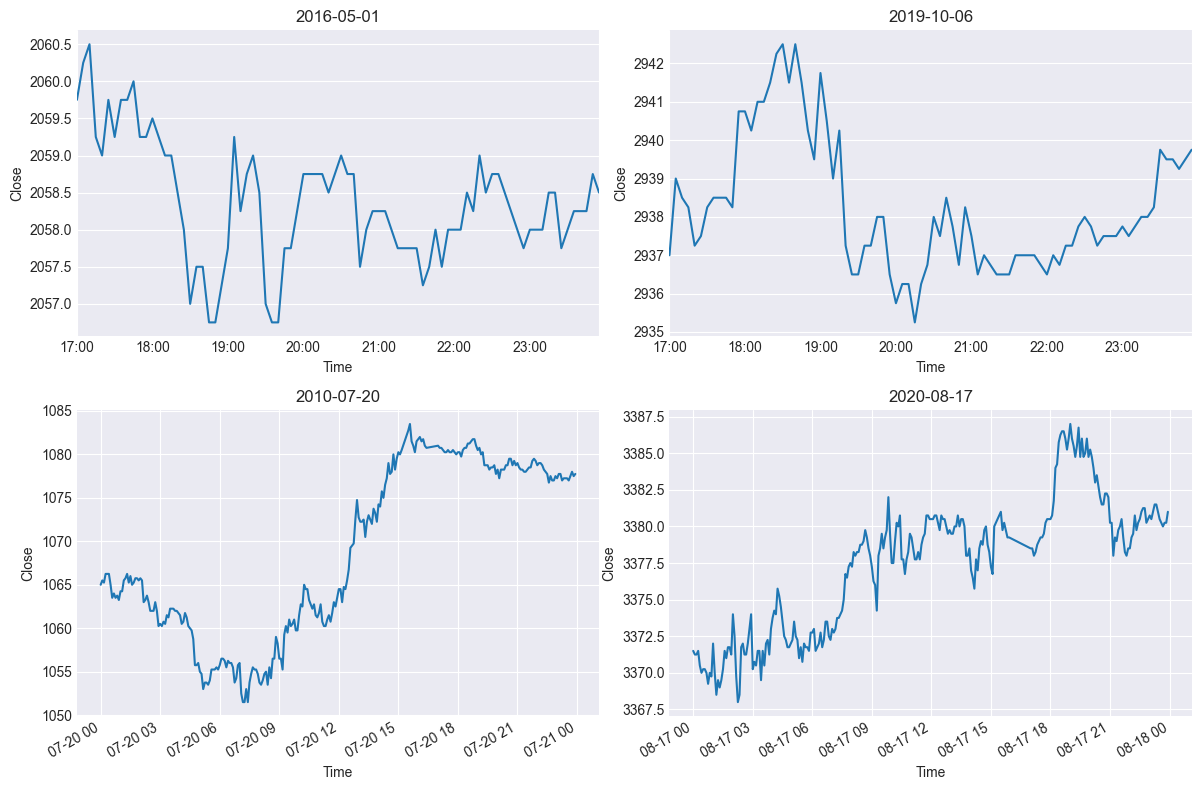

In [17]:
# pick 4 random days
all_days = es_5min.index.normalize().unique().date
days = np.random.choice(all_days, size=4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, day in zip(axes.ravel(), days):
    es_5min.loc[str(day), "close"].plot(ax=ax)
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.set_xlabel("Time")
    ax.set_ylabel("Close")

plt.tight_layout()
plt.show()

There are some interpolated prices, but oeverall teh quality looks good comapred to yfinance for isnatcne where msot of the series would be interpolated.

In [18]:
daily_rv = rvvol.rv_intraday(es_5min["close"])
es_rv_21 = np.sqrt(daily_rv.rolling(21).mean() * 252)

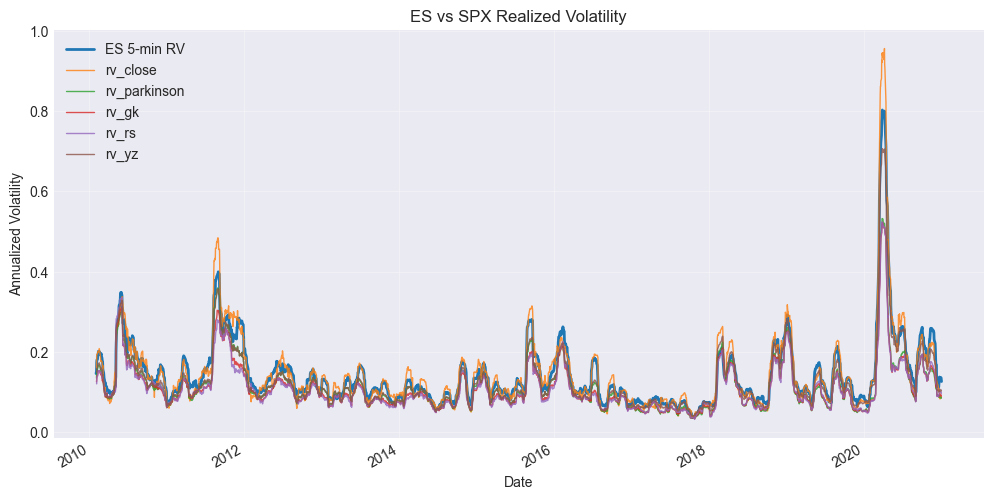

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

es_rv_21.plot(ax=ax, label="ES 5-min RV", lw=2)
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax, lw=1, alpha=0.8)

ax.set_title("ES vs SPX Realized Volatility")
ax.set_ylabel("Annualized Volatility")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

The difference between close-to-close and realized variance is evne more pormiennt at daily frequency.

# **3. Stylized Facts of Daily Volatility**

In this section we investigate several well-established stylized facts of daily volatility that are directly relevant for forecasting. The goal is to highlight key empirical properties of daily variance that can be exploited when building predictive models.

**From a modelling perspective, we work with daily realized variance rather than monthly rolling volatility because:**
1. **Variance is additive over time**, while standard deviation is not — making variance a more coherent object for multi-horizon forecasts (e.g., 21-day forward variance).
2. The stylized facts documented in the volatility literature (**persistence, clustering, long memory, leverage effects**, etc.) are formulated at the **daily frequency**, not on monthly-smoothed series.

These empirical observations serve as the theoretical motivation for the feature construction and model specifications used throughout the notebook.

## 3.1 Volatility clustering

Volatility does not evolve randomly from day to day — instead, it exhibits persistent regimes. Periods of high volatility tend to be followed by high volatility, and periods of low volatility tend to be followed by low volatility.

This phenomenon, known as volatility clustering, is one of the most robust empirical facts in financial time series and is foundational for volatility modelling. It implies that recent volatility contains information about future volatility, which justifies the use of lagged realized variance measures (e.g., daily, weekly, monthly RV) as predictors in HAR-type models.

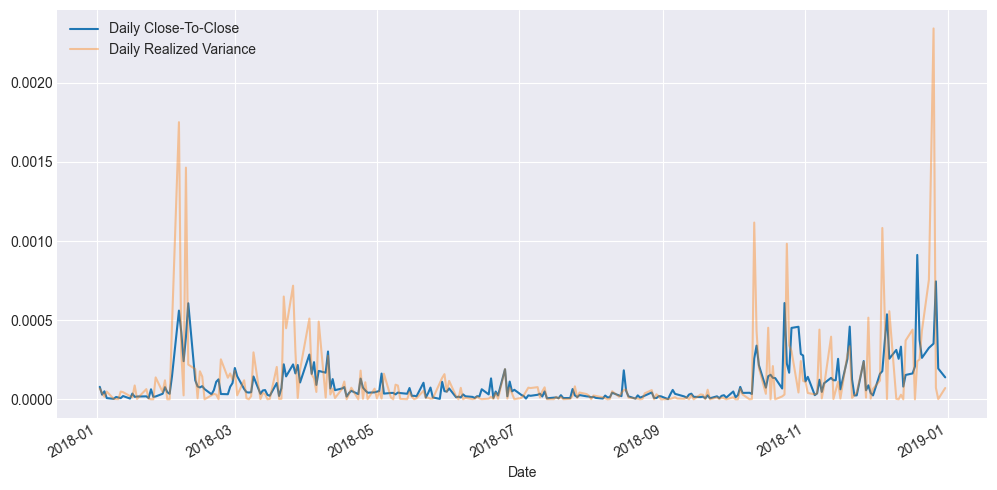

In [20]:
daily_c2c = spx["returns"].pow(2)

plt.figure(figsize=(12, 6))
daily_rv.loc["2018"].plot(alpha=1, label="Daily Close-To-Close")
daily_c2c.loc["2018"].plot(alpha=0.4, label="Daily Realized Variance")
plt.legend()
plt.show()

## 3.2 Long Memory / Slow Decay

Squared returns and realized variance display **very slow autocorrelation decay**, a phenomenon often described as long memory.
This means today’s volatility contains predictive information not only for the next few days, but even for **several weeks or months ahead.**

This empirical fact motivates the structure of **HAR-RV models**, which include volatility lags at different horizons (daily, weekly, monthly). HAR provides a parsimonious way to approximate long-memory behaviour without requiring a large number of parameters.

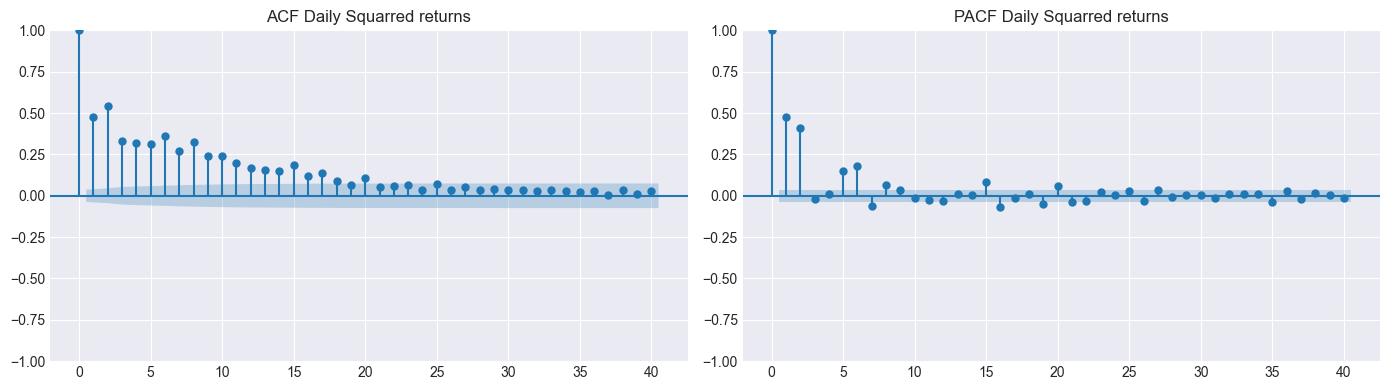

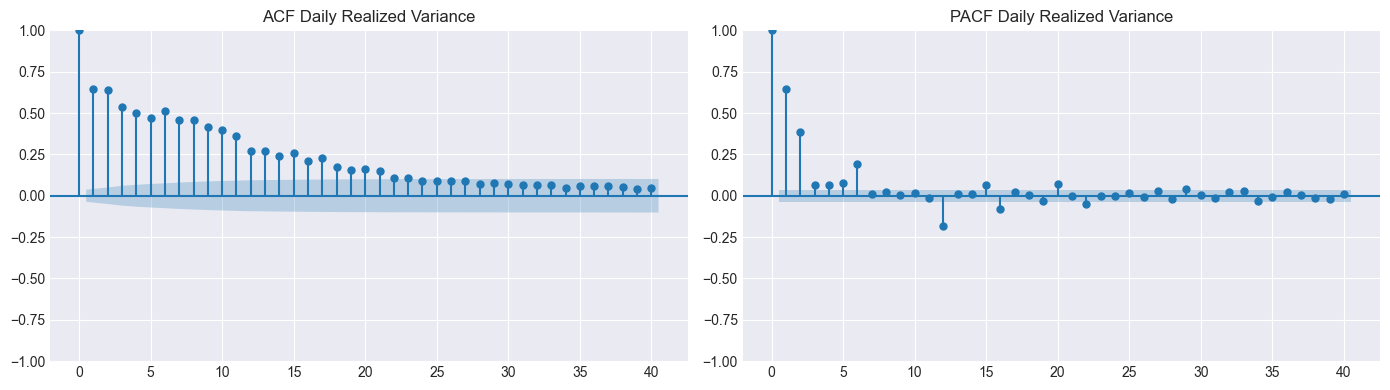

In [21]:
ph.plot_acf_pacf(daily_c2c, lags=40, title="Daily Squarred returns")
ph.plot_acf_pacf(daily_rv, lags=40, title="Daily Realized Variance")

Here we can see that the ACF of realized varaicn eis much more peristent that the saurred returns and is clearly persistent until the 21-th lags.

## 3.3 Mean-reverting behaviour

Volatility is **mean-reverting**: after a shock—whether a volatility spike or a collapse—it tends to slowly drift back toward its long-run unconditional level.
The reversion is not instantaneous; it occurs gradually over time, reflecting persistent but ultimately temporary deviations from equilibrium.

This property is foundational in volatility modelling and supports the use of **autoregressive structures** (e.g., HAR, GARCH) that capture both persistence and eventual reversion.

In [22]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model
model = AutoReg(daily_rv.to_numpy(), lags=1, old_names=False)
res = model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2835
Model:                     AutoReg(1)   Log Likelihood               19576.101
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 13 Nov 2025   AIC                         -39146.202
Time:                        16:52:31   BIC                         -39128.354
Sample:                             1   HQIC                        -39139.764
                                 2835                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.869e-05   4.81e-06      8.045      0.000    2.93e-05    4.81e-05
y.L1           0.6461      0.014     45.068      0.000       0.618       0.674
                                    Roots           

The regression coefficient sugguest that the variance has mean-reverting property that can be leveraged in autoregression mdoel like **GARCH**

## 3.4 Volatility distributions are often log-normal

Volatility is strictly positive, highly right-skewed, and empirically close to log-normal. In practice, while raw volatility measures (RV, IV) exhibit heavy right tails and large outliers, their logarithm is much closer to a Gaussian distribution.

**Why log-volatility is preferred**
- **Positivity:** Modeling log-volatility ensures that forecasts, once exponentiated, are always ≥ 0.
- **Statistical convenience:** Log-volatility has a distribution much closer to Normal → residuals from regressions are more symmetric and homoscedastic.
- **Better predictive behaviour:** Many linear and autoregressive models (HAR, ARMA, regressions) fit significantly better on log-transformed volatility.

These properties make the log-volatility transformation a standard step in volatility forecasting models. 

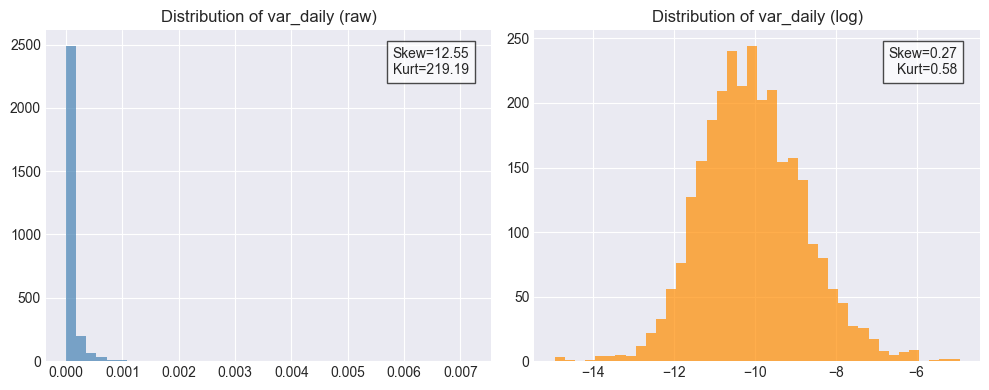

In [23]:
ph.plot_hist_transform(daily_rv, use_log=True, figsize=(10,4))

## 3.5 Leverage Effect / Asymmetric Return–Volatility Relationship

Another key stylized fact is the asymmetric relationship between returns and volatility:
- **Negative returns** (price drops) tend to increase future volatility more than positive returns of the same magnitude.
- This phenomenon is known as the **leverage effect**: when the equity price falls, financial leverage rises, making the firm riskier and increasing volatility.
- Empirically, this produces an asymmetric correlation:
  
$$\operatorname{Corr}(r_t,\ \sigma^2_{t+h}) < 0.$$

**Modeling implications**
- **Symmetric** volatility models (e.g., standard GARCH) cannot capture this effect.
- **Asymmetric / leverage-sensitive** models—EGARCH, GJR-GARCH, Heston with leverage, etc.—are designed to incorporate it.
- For **RV forecasting**, include **downside-biased return measures** (e.g., negative returns, downside semivariance) as predictive features.

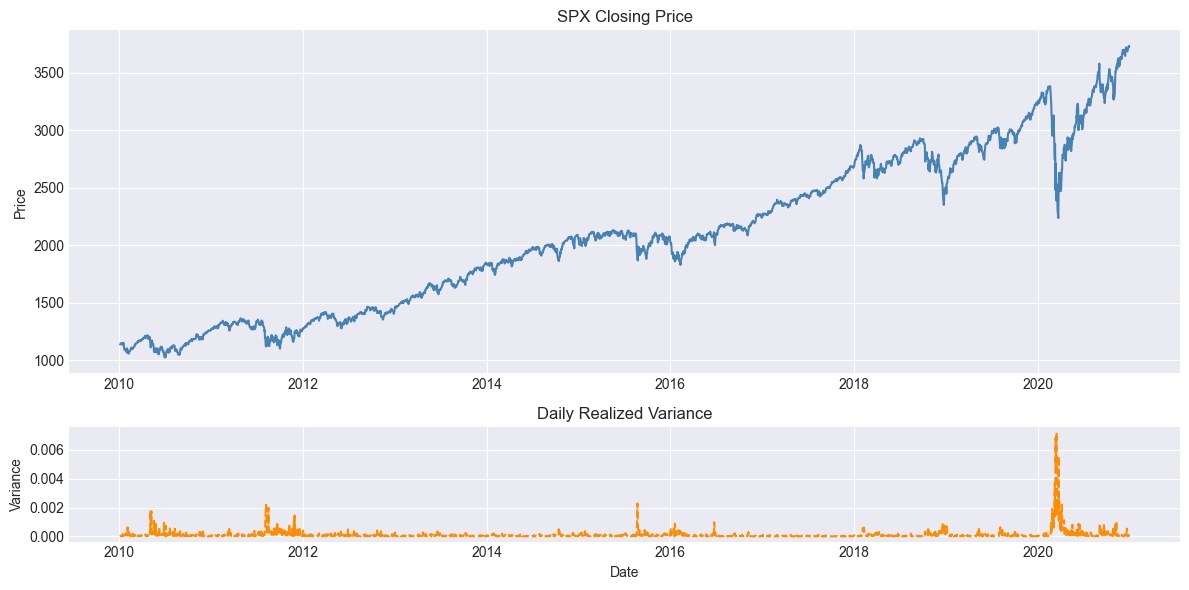

In [24]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# SPX closing price
ax1 = fig.add_subplot(gs[0])
ax1.plot(spx.index, spx["Close"], color="steelblue")
ax1.set_title("SPX Closing Price")
ax1.set_ylabel("Price")

# realized volatility
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(daily_rv.index, daily_rv, color="darkorange", linestyle="--")
ax2.set_title("Daily Realized Variance")
ax2.set_ylabel("Variance")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

Here we can se ethat big drops occuring arround 2012, 2016 and 2020 covid crash are associated with higher vraaince


---

# **4. Problem Formulation**

We frame the task as a supervised learning problem: forecasting the 21-day forward realized volatility of the S&P 500.

Formally, the objective is to predict forward realized volatility using only information available at time $t$.  

$$
y_t = f(X_t; \beta) + \varepsilon_t, \quad \text{with } \mathbb{E}[y_t | X_t] = f(X_t; \beta)
$$

where:
- $y_t$ = target variable (forward 21-day realized volatility),
- $X_t$ = vector of predictors at time $t$.
- $f(.;\beta)$ = parametric or non-parametric form of the regressors


## 4.1 Target Variable: 21-Day Realized Variance

For forecasting purposes, it is convenient to define the target in terms of **daily realized volatility** averaged over the forward horizon. Since realized variance and volatility are highly skewed and approximately log-normal, we work in the **logarithmic scale**:

$$
y_t = \log\!\big(RV_{t+1:t+21}\big)
$$

where the forward 21-day realized variance aligned at time $t$ is defined as:

$$
RV_{t+1:t+21} 
= \frac{RV_{t+1} + RV_{t+2} + \cdots + RV_{t+21}}{21}
$$

with $RV_{t+i}$ denoting the one-day realized volatility computed from intraday (5-min) returns.

- The **log transform** reduces skewness, stabilizes variance, and makes the distribution closer to Gaussian.  
- It also guarantees positivity when transformed back:

$$
\hat{RV}_{t+1:t+21} = \exp(\hat{y}_t).
$$

In [25]:
H = 21
y = rvfeat.create_forward_target(daily_rv, horizon=H)

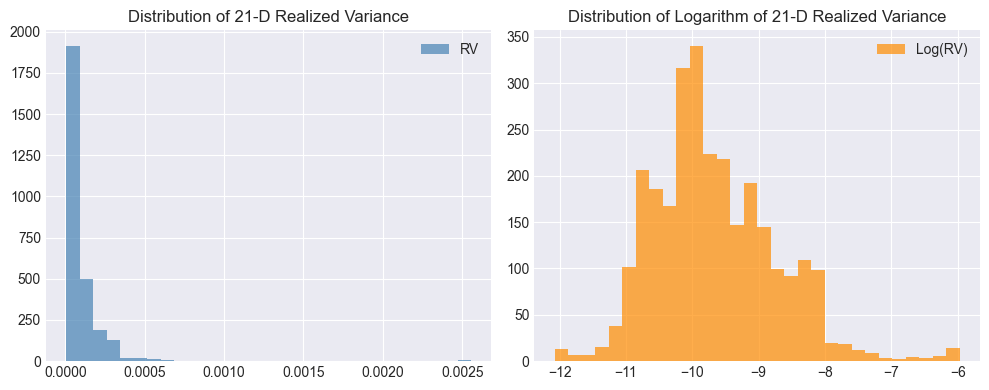

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

np.exp(y).hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of 21-D Realized Variance")
axes[0].legend()

y.hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of Logarithm of 21-D Realized Variance")
axes[1].legend()

plt.tight_layout()
plt.show()

## 4.2 Predictor Families (Information Available at Time $t$)

We use only information observable at time $t$, grouped into predictor families, where each family captures a different aspect of future (forward) RV.

We organise the features into the following blocks:
- **Lagged volatility measures** (daily/weekly/monthly RV)
- **IV surface predictors** (level, slope, skew)
- **Returns-based predictors** (realised returns, downside vs upside moves, overnight returns)
- **Macro & Market Preidctors** (rates, term spread, credit spreads, VIX, VVIX)

For each predictor family we:
- plot the **time series** to see regimes and structural breaks,
- look at the **distribution** to decide on transformations (log, sqrt, winsorisation),
- and inspect **relationship with the target** via scatter / hexbin plots.

### 4.2.1 Lagged Volatility Measures: HAR-RV Lags (1D, 5D, 22D)

As seen in the ACF plots, realized variance displays strong persistence, remaining significant over many daily lags. This motivates using **lagged realized variance** as predictors.

We adopt the standard **HAR-RV (Heterogeneous Autoregressive)** structure, which captures short-, medium- and long-term memory via daily, weekly and monthly averages:

$$
X_{t}^{HAR} = RV_{D,t} + RV_{W,t} + RV_{M,t}
$$

where:
- $RV_{D,t} = RV_{t}$ (daily lag, short-term persistence)  
- $RV_{W,t} = \tfrac{1}{5}\sum_{i=0}^{4} RV_{t-i}$ (weekly average, medium-term)  
- $RV_{M,t} = \tfrac{1}{21}\sum_{i=0}^{20} RV_{t-i}$ (monthly average, long-term)  

This specification smooths noisy daily lags and reflects the **heterogeneous horizons** of market participants (daily traders, weekly rebalancers, monthly institutions).

In [27]:
summary_stats = ['count','mean','std','min','max','skew','kurtosis']

X_har = rvfeat.create_har_lags(daily_rv)
X_har.agg(summary_stats)

RV_D         RV_W         RV_M
count     2.835000e+03  2831.000000  2815.000000
mean      1.092941e-04     0.000109     0.000110
std       3.170964e-04     0.000263     0.000219
min       3.257165e-07     0.000004     0.000006
max       7.191973e-03     0.004678     0.002556
skew      1.255384e+01    10.254128     7.915824
kurtosis  2.195748e+02   135.858842    74.452912

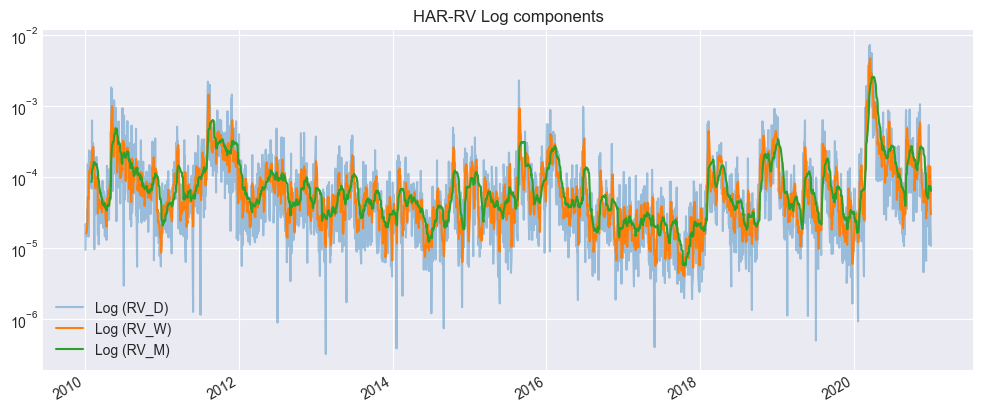

In [28]:
fig, ax = plt.subplots(1,1, figsize=(12, 5))
ax.set_yscale("log")
X_har["RV_D"].plot(ax=ax, alpha=0.4, label="Log (RV_D)")
X_har["RV_W"].plot(ax=ax, alpha=1, label="Log (RV_W)")
X_har["RV_M"].plot(ax=ax, alpha=1, label="Log (RV_M)")
plt.legend(); plt.title("HAR-RV Log components")
plt.show()

The HAR-RV lags evolve closely together over time, but each one captures a different volatility regime:
short-term (1-day), medium-term (5-day), and long-term (21-day/monthly).

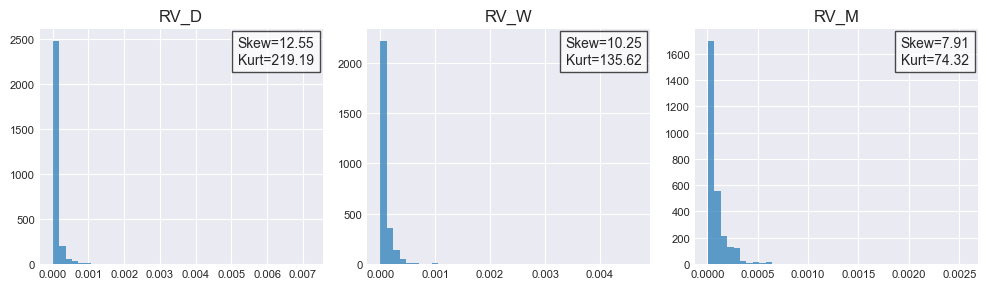

In [29]:
ph.plot_feature_histograms(X_har, figsize=(10, 3))

#### **Transformation Decisions**
- Apply Log transform to: `RV_D`, `RV_W`, `RV_M`.

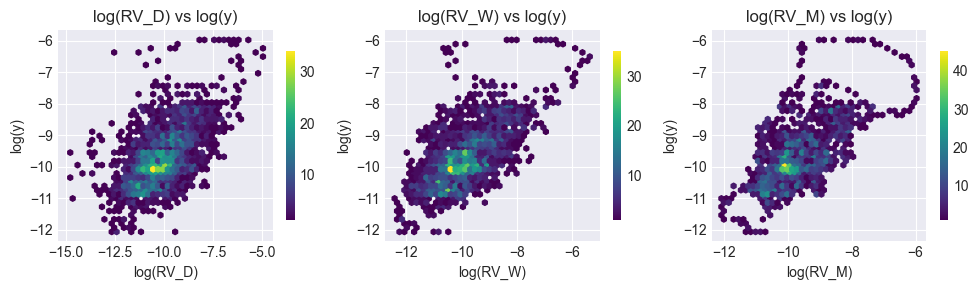

In [30]:
ph.plot_features_vs_target(X_har, y, log_features=X_har.columns.tolist(), figsize=(10, 3), nrows=1, ncols=3)

Each predictor shows a **clear linear relationship** with the target in the log space, which helps explain why the **HAR-RV model is so popular** and widely used as a benchmark.

### 4.2.2 Implied Volatility Surface Predictors 

Realized volatility lags capture **persistence**, while implied volatility (IV) carries the market’s **forward-looking expectations** and risk premia. We use:

- **ATM IV (1M)**  
  Near-the-money 1-month IV, tightly linked to option premia and cleaner than broad indices like VIX.

- **25Δ IV Skew (Risk Reversal)**  
  Captures the **downside risk premium** and crash-protection demand: steeper (more negative) skew ↔ stronger tail-risk pricing.

- **IV Term Structure**  
  Front-loaded (short > long) IV usually signals near-term stress; an upward slope is consistent with calmer, mean-reverting regimes.

These IV predictors complement HAR-RV lags by adding a **market-implied view of future volatility**.

### SPX option chain

We first load the SPX option chain and add basic surface coordinates: time-to-maturity $T$ and log-moneyness $k = \log(K/S)$.

In [34]:
spx_options = pd.read_parquet("../data/intermediate/full_spx_options_2010_2020.parquet")
spx_options["T"] = spx_options["dte"] / 252 
spx_options["k"] = np.log(
    spx_options["strike"] / spx_options["underlying_last"]
 )
spx_options.head()

underlying_last     expiry  dte  strike  strike_distance  \
date                                                                   
2010-01-04          1132.99 2010-01-07  3.0   925.0            208.0   
2010-01-04          1132.99 2010-01-07  3.0   950.0            183.0   
2010-01-04          1132.99 2010-01-07  3.0   975.0            158.0   
2010-01-04          1132.99 2010-01-07  3.0  1000.0            133.0   
2010-01-04          1132.99 2010-01-07  3.0  1025.0            108.0   

            strike_distance_pct  c_delta  p_delta  c_gamma  p_gamma  ...  \
date                                                                 ...   
2010-01-04                0.184      1.0 -0.00077      0.0  0.00004  ...   
2010-01-04                0.162      1.0 -0.00203      0.0  0.00006  ...   
2010-01-04                0.139      1.0 -0.00369      0.0  0.00022  ...   
2010-01-04                0.117      1.0 -0.00894      0.0  0.00038  ...   
2010-01-04                0.095      1.0 -0.01251      0.0  0.00066  ...   

             c_bid  p_bid   c_ask  p_ask  c_size_bid  p_size_bid  c_size_ask  \
date                                                                           
2010-01-04  205.99   0.00  208.99   0.06       101.0         0.0       101.0   
2010-01-04  181.00   0.00  184.00   0.10       101.0         0.0       101.0   
2010-01-04  156.00   0.05  159.00   0.10       101.0       717.0       101.0   
2010-01-04  131.10   0.15  134.10   0.21       101.0       470.0       101.0   
2010-01-04  106.21   0.20  109.20   0.25       101.0       428.0       101.0   

            p_size_ask         T         k  
date                                        
2010-01-04       420.0  0.011905 -0.202822  
2010-01-04       455.0  0.011905 -0.176153  
2010-01-04       177.0  0.011905 -0.150178  
2010-01-04        98.0  0.011905 -0.124860  
2010-01-04        63.0  0.011905 -0.100168  

[5 rows x 32 columns]

### SSVI-based IV surface predictors

We then calibrate an SSVI surface slice-by-slice and extract a small set of IV-based predictors (ATM level, skew, term structure, etc.) aligned to the RV target dates.

In [35]:
ssvi = SSVI()
df_g = pd.read_parquet("ssvi_globals_2010_2020.parquet")
df_k = pd.read_parquet("ssvi_knots_2010_2020.parquet")

params_ssvi = ssvi.build_params_dict(df_g, df_k)
X_iv_surface = rvfeat.create_iv_surface_predictors(spx_options, ssvi, params=params_ssvi)
X_iv_surface = X_iv_surface.reindex(y.index).ffill()

X_iv_surface.agg(summary_stats)

FileNotFoundError: [Errno 2] No such file or directory: 'ssvi_globals_2010_2020.parquet'

### Correct data error from iv puts

A few IV-surface days are clearly erroneous / inconsistent (incorrect data error from IV put). We set those dates to NaN and linearly interpolate to avoid contaminating the predictors.

In [36]:
X_iv_surface.loc["2019-05-02":"2019-05-08", :] = np.nan
X_iv_surface.loc["2019-05-17", :] = np.nan
X_iv_surface = X_iv_surface.interpolate(method="linear")

X_iv_surface.agg(summary_stats)

NameError: name 'X_iv_surface' is not defined

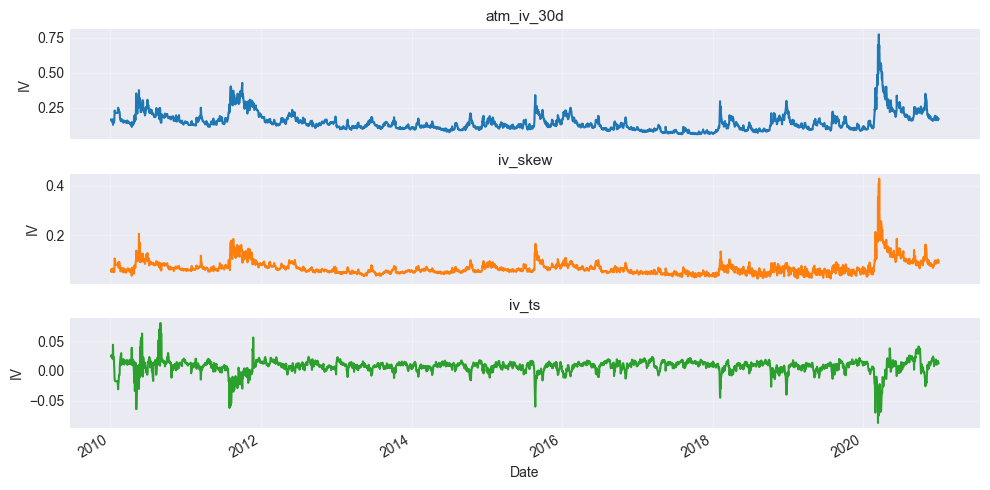

In [ ]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green, red
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

for ax, col, c in zip(axes.flat, X_iv_surface.columns, colors):
    X_iv_surface[col].plot(ax=ax, lw=1.5, color=c)
    ax.set_title(col, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Date")
    ax.set_ylabel("IV")
    
plt.tight_layout()
plt.show()

We see that during market stress, **ATM IV spikes**, the **skew steepens**, and the **IV term structure inverts** (front-month IV ≫ back-month IV).

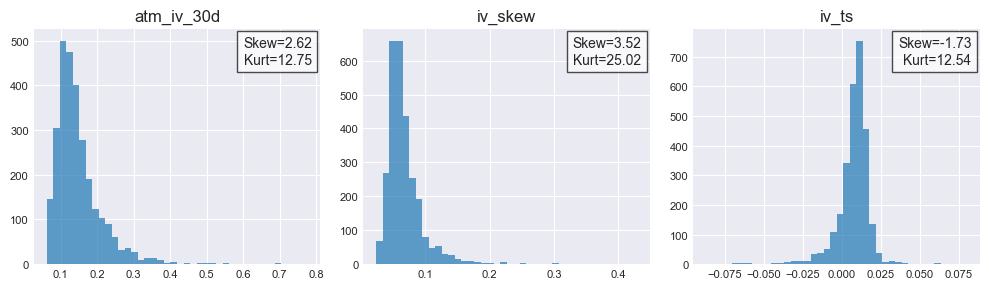

In [ ]:
ph.plot_feature_histograms(X_iv_surface, figsize=(10, 3))

#### **Transformation Decisions**
- Apply Log transform to: `iv_atm_60`, `iv_skew`.
- Apply Winsorization to: `iv_ts`

During market crashes the IV spike, skew steepens, the Iv-term strcutrue gets inverted.

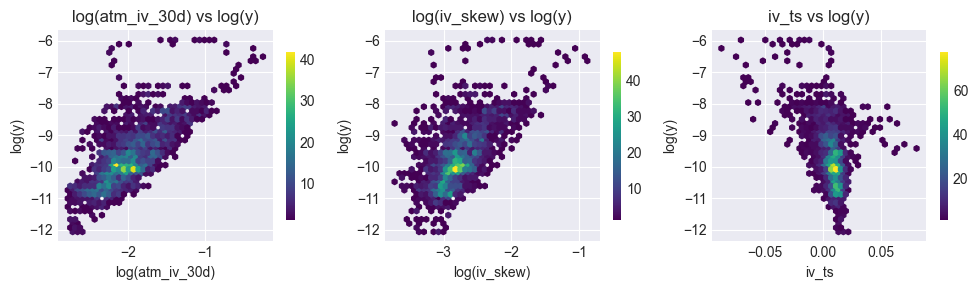

In [ ]:
ph.plot_features_vs_target(X_iv_surface, y, log_features=["atm_iv_30d", "iv_skew"], figsize=(10, 3), nrows=1, ncols=3)

Here, a **higher ATM IV level** and a **steeper skew** are associated with **higher forward 21-day realized variance**, whereas the relationship is **negative for the IV term structure** (more inverted term structure → higher future RV).

### 4.2.3 Return-Based Predictors  

Realised volatility is tightly linked to the behaviour of **recent returns**, but raw daily returns are very noisy.  
Since our target is **21-day RV**, we summarise returns over **short rolling windows** (e.g. 5 trading days) to extract more stable signals:

- **Volatility clustering / persistence**  
  Rolling averages of **absolute** and **squared** returns capture the current volatility regime (calm vs stressed).

- **Asymmetry / leverage effect**  
  Large **negative** returns tend to increase future volatility more than positive ones of the same magnitude. We proxy this via downside-focused measures (e.g. rolling sums of negative returns).

- **Jumps / overnight moves**  
  Large overnight gaps ($Open_t$ - $Close_{t−1}$) often reflect news shocks and regime shifts, and are typically followed by higher RV.

- **Shape of the recent return distribution**  
  Rolling **realised skewness** and **kurtosis** capture asymmetry and tail thickness of recent returns, both of which are associated with stressed markets.

These return-based predictors complement HAR-RV lags and IV-based features by encoding **recent realised price dynamics**.

In [ ]:
X_returns = rvfeat.create_return_predictors(spx["returns"], es_5min, h=H)
X_returns = X_returns.reindex(y.index).ffill()
X_returns.agg(summary_stats)

overnight_ret        abs_r            r2       neg_r2      down_var  \
count       2830.000000  2830.000000  2.830000e+03  2826.000000  2.813000e+03   
mean           0.000306     0.007043  1.217114e-04     0.000057  6.564926e-05   
std            0.003318     0.006107  3.871663e-04     0.000197  1.870573e-04   
min           -0.030006     0.000581  3.711225e-07     0.000000  4.745243e-07   
max            0.023852     0.085571  8.078781e-03     0.004156  2.249933e-03   
skew          -0.408708     4.938071  1.351947e+01    13.307585  9.039184e+00   
kurtosis       9.990675    43.773244  2.319493e+02   218.484532  9.238763e+01   

               up_var         skew         kurt  
count     2813.000000  2813.000000  2813.000000  
mean         0.000057     0.191340     3.408498  
std          0.000124     0.992732     1.400154  
min          0.000003    -3.208464     1.457295  
max          0.001509     3.399189    13.121545  
skew         8.188091     0.199356     1.840437  
kurtosis    77.965242    -0.182521     5.160144

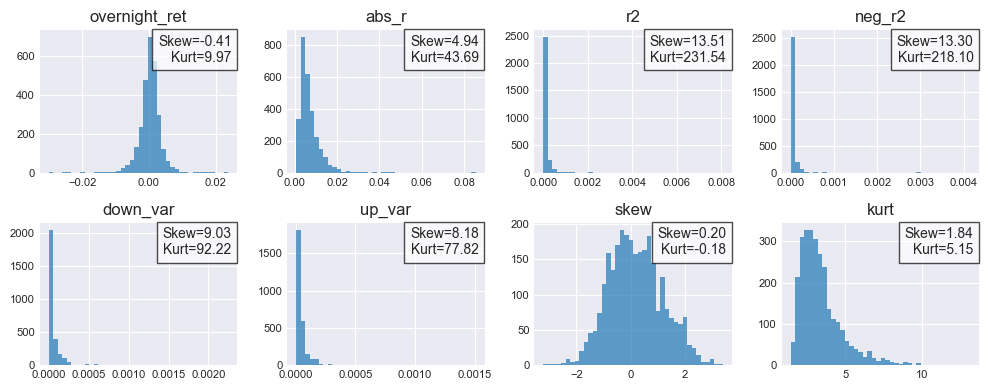

In [ ]:
ph.plot_feature_histograms(X_returns, figsize=(10, 4))

#### **Transformation Decisions**
- Apply `log` transform to: `abs_r`, `r2`, `down_var`, `up_var`, `kurt`
- Apply `winsorization` transform to: `overnight_ret`
- Apply `sqrt` + `winsorization` transform to: `neg_r2`

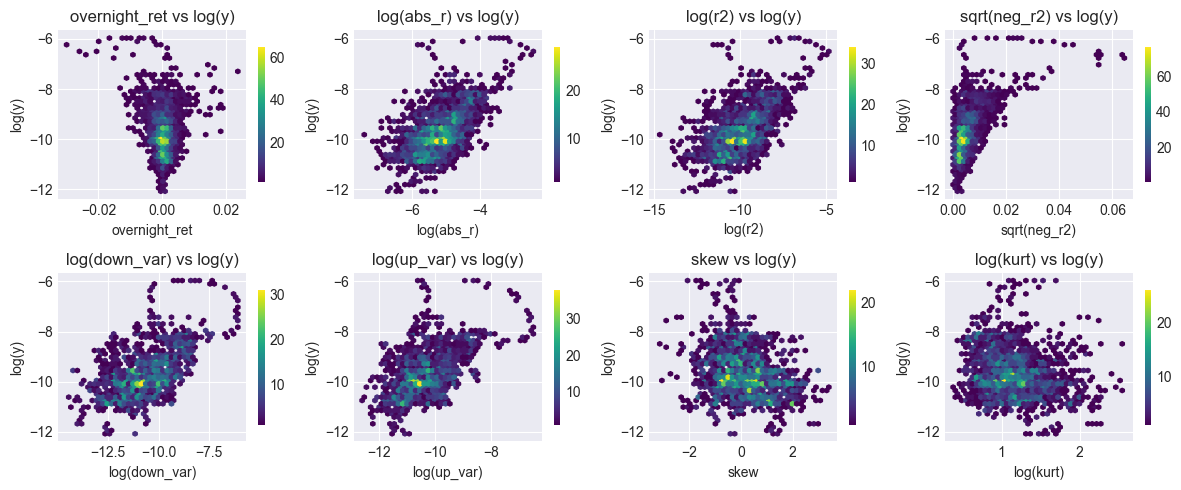

In [ ]:
log_features_ret = ["abs_r", "r2", "down_var", "up_var", "kurt"]
sqrt_features_ret = ["neg_r2"]
ph.plot_features_vs_target(X_returns, y, log_features=log_features_ret, sqrt_features=sqrt_features_ret, figsize=(12, 5), nrows=2, ncols=4)

### 4.2.4 Macro & Market Predictors  

This block mixes **macro fundamentals** (rates, credit spreads) with **market-based indicators** (VIX and VVIX).  
On their own they are usually **weaker forecasters** than RV lags or IV signals, but they help capture **regime shifts** and can be exploited by more flexible models (e.g. RF).

#### Macro Fundamentals  

We include **slow-moving economic and financial variables** such as:

- **Interest rate levels & term spreads**: 3M / 2Y / 10Y Treasury yields, yield-curve slope.  
- **Credit spreads**: IG and HY option-adjusted spreads as proxies for systemic stress.

These variables do not explain day-to-day volatility, but they are useful to identify **macro regimes**  
(e.g. tight monetary policy, widening credit spreads) that can change the level and persistence of forward RV.

In [ ]:
X_macro = rvfeat.create_macro_features(start=start, end=end)
X_macro = X_macro.reindex(y.index).ffill()
X_macro.agg(summary_stats)

DGS10         DGS2       DGS3MO  term_spread_10y_3m  \
count     2835.000000  2835.000000  2835.000000         2835.000000   
mean         2.265898     0.908762     0.556808            1.709090   
std          0.692320     0.747118     0.776442            0.958803   
min          0.520000     0.110000     0.000000           -0.520000   
max          4.010000     2.980000     2.490000            3.830000   
skew        -0.243451     1.162005     1.339041           -0.086261   
kurtosis     0.188206     0.250079     0.240950           -0.607675   

               HY_OAS       IG_OAS  
count     2835.000000  2835.000000  
mean         5.045884     1.507993  
std          1.278209     0.386707  
min          3.160000     0.900000  
max         10.870000     4.010000  
skew         0.777947     1.348852  
kurtosis     0.104021     2.877455

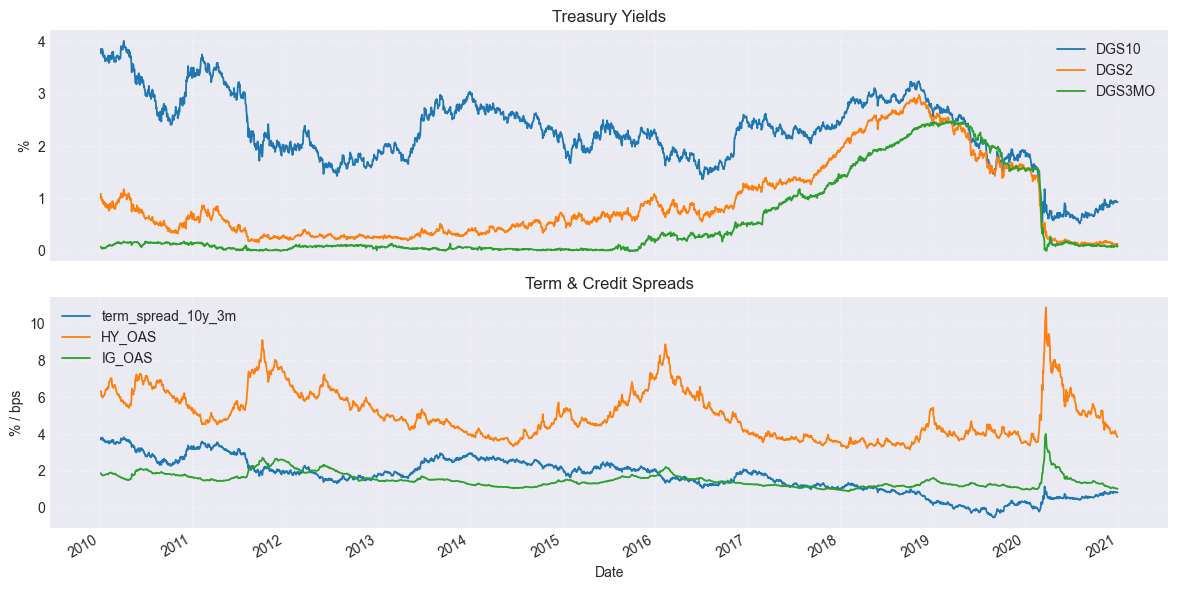

In [ ]:
ph.plot_macro_block(X_macro)

The widening of the credit spreads line up with stress episodes (Euro crisis, 2015–16, Covid), which are also periods of elevated forward RV.

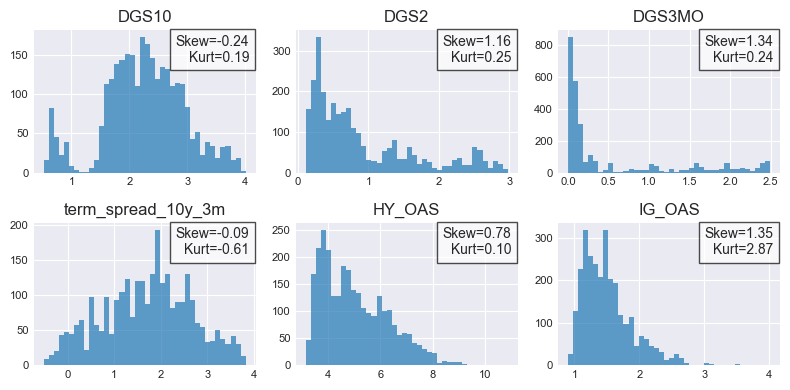

In [ ]:
ph.plot_feature_histograms(X_macro, figsize=(8, 4), nrows=2, ncols=3)

#### **Transformation Decisions**
- No data transformation is needed (of course scaling for linear models)

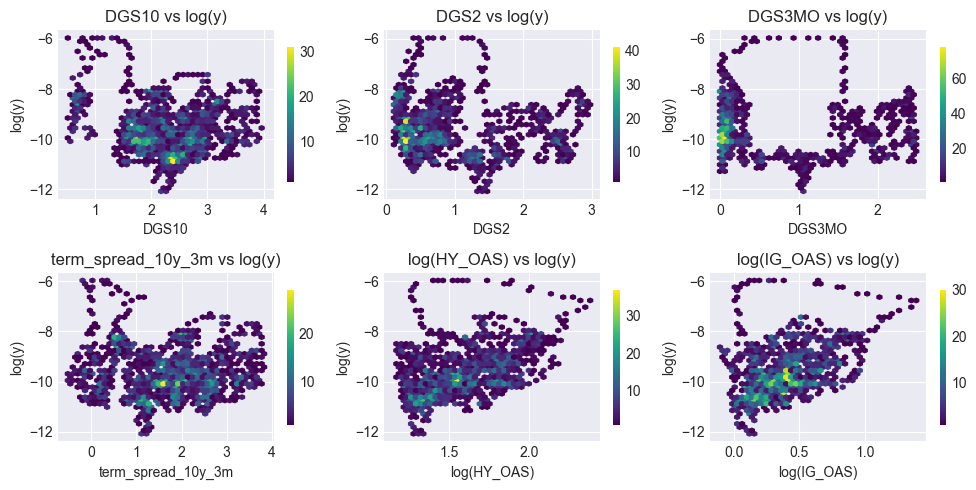

In [ ]:
ph.plot_features_vs_target(X_macro, y, log_features=["HY_OAS", "IG_OAS"], figsize=(10, 5), nrows=2, ncols=3)

In the post-GFC low-rate regime, the 3-month Treasury yield (DGS3MO) is **essentially stuck near zero** up to about 2017, so it carries very little **independent variation**. Since its information is already **embedded in the term-spread variable** term_spread_10y_3m, we drop DGS3MO and keep the spread as the macro predictor.

In [ ]:
X_macro = X_macro.drop("DGS3MO", axis=1)

#### Market / Sentiment  

We also include **market-implied risk indicators** that move faster than macro variables and help identify **risk-on / risk-off regimes**:

- **VIX** – 30-day S&P 500 implied volatility; a fast barometer of market fear and near-term uncertainty.  
- **VVIX** – “vol of vol”; measures uncertainty about future changes in VIX and often spikes in unstable vol regimes.  

These do not describe the asset’s volatility directly, but provide **high-frequency information on risk appetite**, useful as **conditioning variables** for IV–RV forecasts.

In [ ]:
X_market = rvfeat.create_market_features(start=start, end=end)
X_market = X_market.reindex(y.index).ffill()

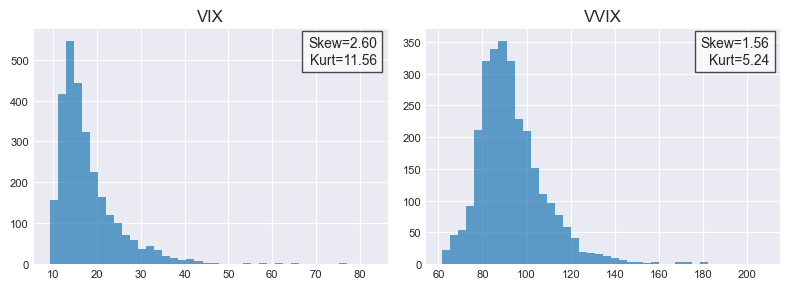

In [ ]:
ph.plot_feature_histograms(X_market, figsize=(8, 3))

#### **Transformation Decisions**
- Apply `log` transform to: `VIX`, `VVIX`

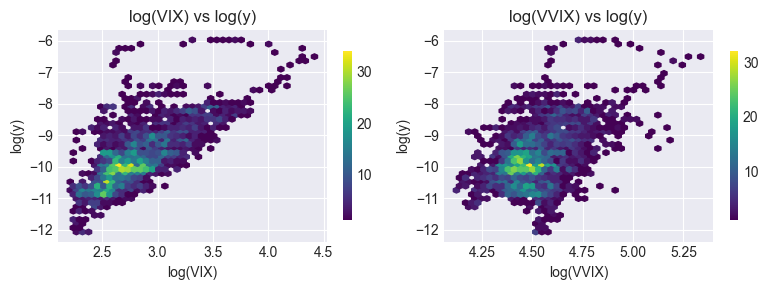

In [ ]:
ph.plot_features_vs_target(X_market, y, log_features=["VIX", "VVIX"], figsize=(8, 3))

# **5. Feature Engineering**

We go beyond raw predictors (HAR lags, VIX, IV surface, credit spreads, etc.) by creating features that are more aligned with the forecasting task. The goal is to reduce noise, capture regime levels, and detect stress transitions that precede volatility spikes.  

- **Horizon-aligned smoothing:** The target is 21-day forward realized variance, so daily predictors are too noisy. We create regime-level signals that capture persistent volatility regimes instead of one-day noise.  

- **Regime shift / stress dynamics:** Volatility surges usually follow abrupt risk repricing. To capture this we add regime change features like momentum in VIX and SKEW as well as intercation effects like VVIX and VIX.

In [ ]:
X_core = pd.concat([X_har, X_iv_surface, X_macro, X_returns, X_market], axis=1)
X_eng = rvfeat.feature_engineering(X_core)
X = pd.concat([X_core, X_eng], axis=1)
X = X.dropna(axis=0)

core_features = X_core.columns.tolist()
eng_features = X_eng.columns.tolist()

X_eng.agg(summary_stats)

VIX_rm5     VIX_rm21     VIX_ewma    RV_D_ewma  HY_OAS_ewma  \
count     2835.000000  2835.000000  2835.000000  2835.000000  2835.000000   
mean        17.971053    17.960360    17.969347     0.000109     5.049248   
std          7.259670     6.853001     7.046994     0.000240     1.263522   
min          9.376000     9.800000     9.614762     0.000004     3.233705   
max         74.618001    61.258572    65.811602     0.003825     9.377609   
skew         2.536454     2.301621     2.402397     9.136190     0.713000   
kurtosis    10.793452     8.074845     9.234084   104.384005    -0.209626   

              dVIX_5d     dSkew_5d  iv_minus_realized  vvix_over_vix  \
count     2830.000000  2830.000000        2815.000000    2835.000000   
mean         0.005693     0.000061           0.149081       5.655410   
std          3.593055     0.018515           0.066756       1.435551   
min        -21.100002    -0.225512           0.062051       2.054459   
max         35.850002     0.234780           0.774351      10.316940   
skew         1.683577     1.018086           2.616658       0.373912   
kurtosis    14.954005    37.015940          12.701030       0.257500   

          VIX_time_HY_OAS  RV_D_rollvol5  RV_D_rollvol21  
count         2835.000000    2831.000000     2815.000000  
mean            97.091306       0.000081        0.000109  
std             68.567904       0.000181        0.000209  
min             30.979201       0.000001        0.000003  
max            707.040000       0.002710        0.002145  
skew             3.348497       8.036214        6.563821  
kurtosis        18.603871      86.449242       52.444094

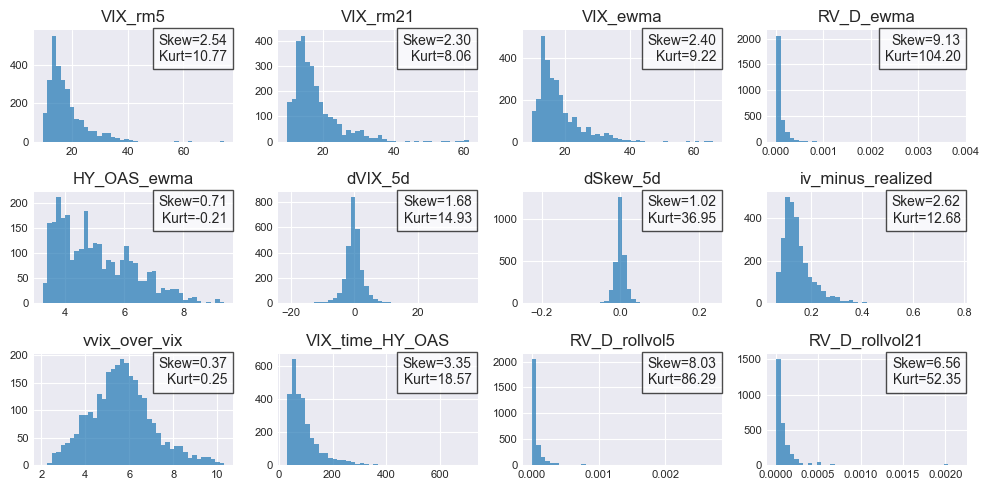

In [ ]:
ph.plot_feature_histograms(X_eng, figsize=(10, 5))

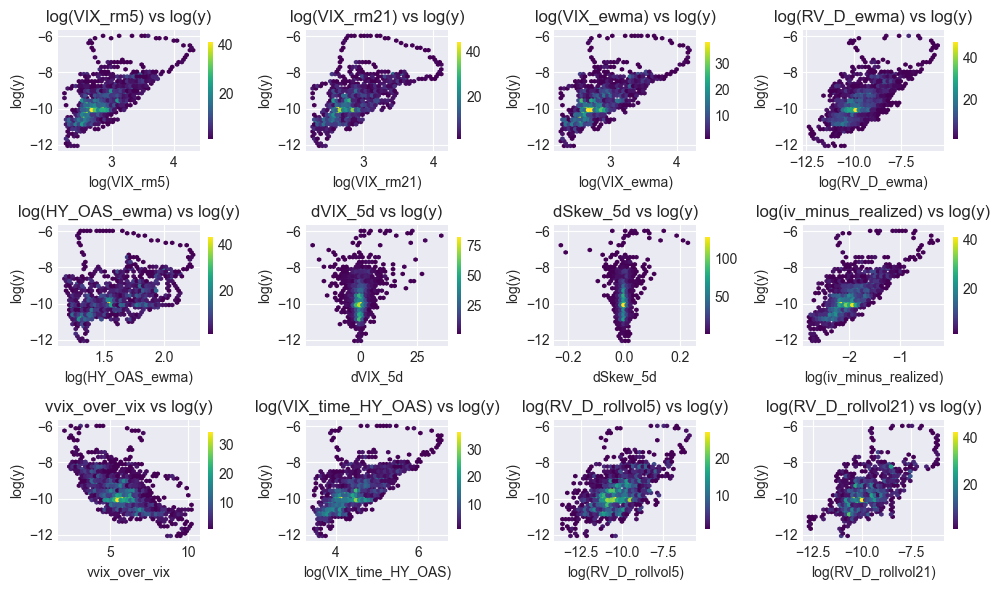

In [ ]:
log_features_eng = list(set(eng_features) - set(["dVIX_5d", "dSkew_5d", "vvix_over_vix"]))
ph.plot_features_vs_target(X_eng, y, log_features=log_features_eng, figsize=(10, 6), nrows=3, ncols=4)

In [ ]:
del X_har, X_iv_surface, X_macro, X_returns, X_market, X_core, X_eng

# **6. Data Preprocessing**

We inspect each predictor’s distribution (shape, skewness, tail heaviness) and only transform **when necessary**.  
The goal is to make features **more symmetric** and **well-behaved** for regression and machine learning.

We rely on simple, interpretable transforms:

- **log** for strictly positive, heavy-right-tailed variables (e.g. VIX, kurtosis proxies),
- **sqrt** for variance-like or squared quantities (e.g. squared returns),
- **winsorization** (clipping extreme quantiles) to tame rare but extreme outliers.
- **scaling** apply standard scaling to put all the features on the same scale (essential for linear models)


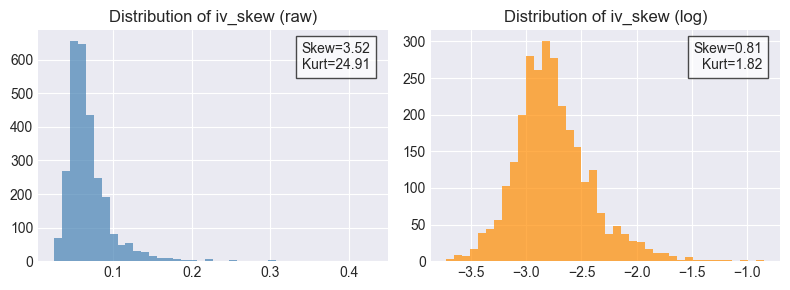

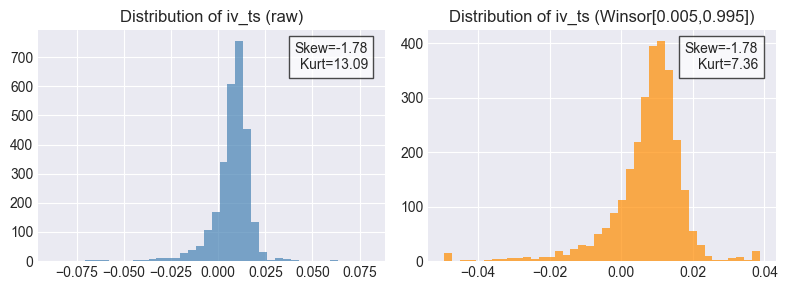

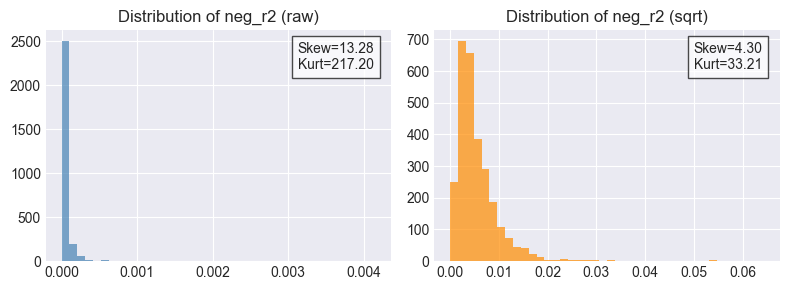

In [ ]:
ph.plot_hist_transform(X["iv_skew"], use_log=True)
ph.plot_hist_transform(X["iv_ts"], winsorize=(0.005, 0.995))
ph.plot_hist_transform(X["neg_r2"], use_sqrt=True)

## Apply the appropiate transformation

We apply all transformations using the `DataProcessor` class, which follows the scikit-learn **Transformer / Pipeline** API:
we **fit** the transformations only on the training set, then **apply** them to both the training and test data.

In [ ]:
log_features = [
    "RV_D", "RV_W", "RV_M", "RV_D_ewma",
    "abs_r", "r2", "down_var", "up_var", "kurt",
    "VIX", "VVIX", "VIX_rm5", "VIX_rm21", "VIX_ewma",
    "atm_iv_30d", "iv_skew", "iv_minus_realized",
    "VIX_time_HY_OAS", 
    "RV_D_rollvol5", "RV_D_rollvol21"
]

winsor_sqrt_features = [
    ([0.0, 0.995], ["neg_r2"])
]

winsor_features = [
    ([0.005, 0.995], ["iv_ts", "overnight_ret"]),
    ([0.001, 0.995], ["dVIX_5d", "dSkew_5d"])
]

dp = DataProcessor(
    log_features=log_features,
    winsor_sqrt_features=winsor_sqrt_features,
    winsor_features=winsor_features,
    scale=True
)

X_proc = dp.fit_transform(X)
X_proc = pd.DataFrame(X_proc, index=X.index, columns=dp.get_feature_names_out())

rng = np.random.default_rng(42)
cols_sample = rng.choice(X_proc.columns, size=8, replace=False)
X_proc[cols_sample[:4]].agg(summary_stats)

HY_OAS_ewma      dSkew_5d          DGS2  RV_D_rollvol5
count     2.813000e+03  2.813000e+03  2.813000e+03   2.813000e+03
mean     -1.010370e-16  4.104628e-18  8.082960e-17   4.142517e-16
std       1.000178e+00  1.000178e+00  1.000178e+00   1.000178e+00
min      -1.429195e+00 -6.151124e+00 -1.065063e+00  -2.896831e+00
max       3.431921e+00  4.908140e+00  2.762229e+00   3.597154e+00
skew      7.329708e-01  3.144251e-01  1.157978e+00   2.735329e-01
kurtosis -1.781129e-01  7.017764e+00  2.258579e-01   2.658720e-01

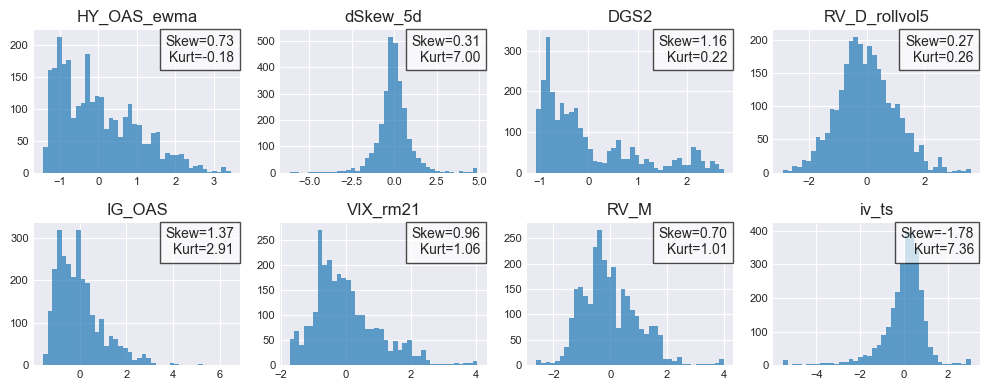

In [ ]:
ph.plot_feature_histograms(X_proc[cols_sample], figsize=(10, 4))

In [ ]:
y = rvfeat.create_forward_target(daily_rv, horizon=21)

data = pd.concat([X_proc, y], axis=1)
data = data.dropna()

X_clean = data[X_proc.columns]
y_clean = data[y.name]

## Correlation / redundancy check

Here we remove **highly correlated features** so that feature-importance scores in the next section are **more stable and easier to interpret**.
We use a **conservative threshold** of $\lvert \rho \rvert = 0.95$ to avoid over-pruning the feature set, since both Lasso and Random Forest are relatively robust to moderate multicollinearity.

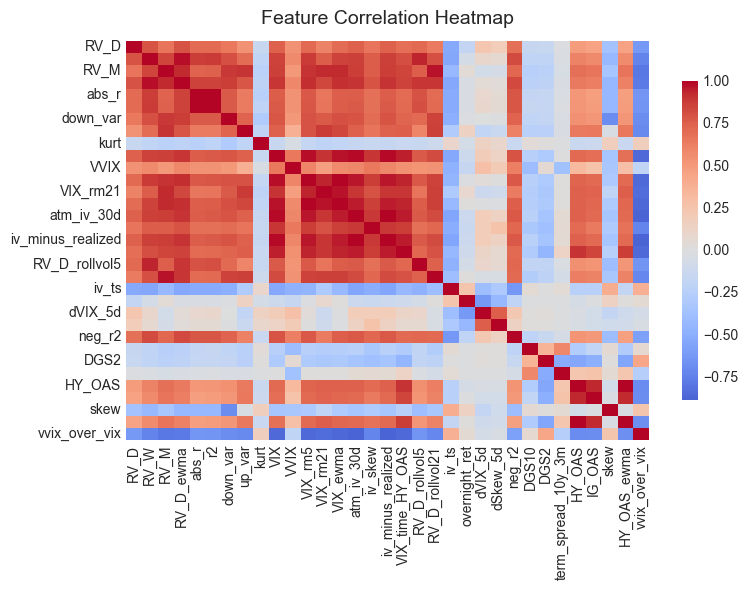

In [ ]:
corr = X_clean.corr()

plt.figure(figsize=(8, 6)) 
sns.heatmap(
    corr,
    cmap="coolwarm",        
    center=0,                   
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Heatmap", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

In [ ]:
corr_threshold = 0.95
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_pairs = (
    upper.stack()
         .loc[lambda s: s > corr_threshold] 
         .sort_values(ascending=False)
)
print(high_pairs)

atm_iv_30d         iv_minus_realized    0.999999
VIX_rm5            VIX_ewma             0.994107
HY_OAS             HY_OAS_ewma          0.990606
abs_r              r2                   0.987160
VIX                atm_iv_30d           0.984047
                   iv_minus_realized    0.983999
                   VIX_rm5              0.972769
RV_W               RV_D_ewma            0.970479
VIX                VIX_ewma             0.966937
VIX_rm21           VIX_ewma             0.965546
RV_M               RV_D_rollvol21       0.964809
VIX_rm5            atm_iv_30d           0.960073
                   iv_minus_realized    0.959925
VIX_ewma           atm_iv_30d           0.955040
                   iv_minus_realized    0.954847
atm_iv_30d         VIX_time_HY_OAS      0.953364
iv_minus_realized  VIX_time_HY_OAS      0.953324
dtype: float64


We decide which columns to drop by keeping the **original, best-documented features**. For example, we keep `VIX` and drop `atm_iv_30d`: they carry very similar information, but **VIX is more widely documented** in the literature as a meaningful predictor.

In [ ]:
corr_features_to_drop = [
    "atm_iv_30d", "iv_minus_realized", "r2",
    "VIX_rm5", "RV_D_ewma", "HY_OAS", "VIX_ewma", "RV_D_rollvol21"
]
X_clean = X_clean.drop(corr_features_to_drop, axis=1)


---

# 7. **Modelling Framework**

## 7.1 Cross-Validation Scheme (Purged K-Fold)

To evaluate feature importance **across time**, we need a CV scheme that respects the time-series structure and avoids look-ahead.

We use a **Purged K-Fold** cross-validation:

- Folds are **contiguous in time** (no shuffling).
- Around each test fold, we **purge** neighbouring observations to remove overlap from:
  - the 21-day RV target horizon, and
  - rolling windows used in the predictors.
- We add a small **embargo** after the test fold to avoid subtle leakage from nearby points.

This produces a sequence of non-overlapping validation blocks over 2010–2020, allowing us to study **feature importance and stability across regimes** while controlling for target overlap.

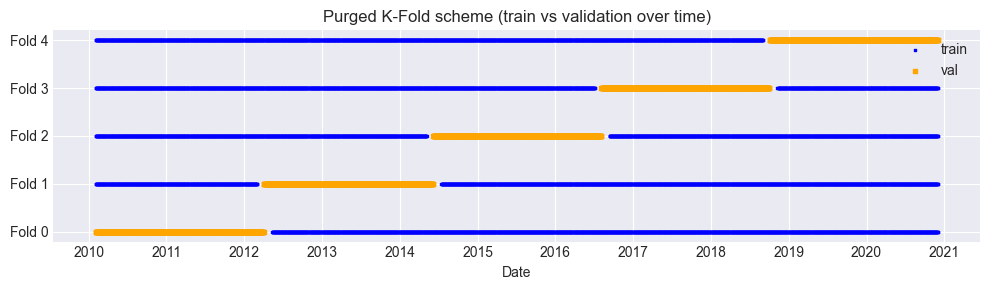

In [ ]:
purged_cv = PurgedKFold(
    n_splits=5,      # ≈ 2-year validation blocks
    purge_gap=21,   # 21-day RV horizon
    embargo=0.01,  # 1% embargo after validation fold
)

ph.plot_purged_kfold_splits(purged_cv, X_clean, y_clean)

## 7.2 Model Specifications  

Building on the volatility-forecasting literature and our exploratory analysis, we use:

- **Linear regression / HAR-type models** as the main econometric benchmark,  
- **Random Forests** as a flexible non-linear alternative.

The modelling path is:

- start from the canonical **HAR-RV** specification,  
- extend to **HAR-RV-X** by adding a small set of predictors with robust predictive power and clear economic meaning  
  (IV level, term structure, VRP, overnight moves, macro spreads, etc.),  
- fit a **Random Forest** on the same feature set and compare its performance and behaviour to the linear models.

### 7.2.1 Linear Models (HAR-RV and HAR-RV-X)  

We consider a baseline **HAR-RV** specification of the form:

$$
\text{RV}^{(21)}_{t+21}
= \beta_0 
+ \beta_D \,\text{RV}^{(1)}_t
+ \beta_W \,\text{RV}^{(5)}_t
+ \beta_M \,\text{RV}^{(21)}_t
+ \varepsilon_{t+21},
$$

where $\text{RV}^{(k)}_t$ denotes a $k$-day average of past daily realized variance (HAR daily/weekly/monthly structure).

We then extend this to a more general **HAR-RV-X** model:

$$
\text{RV}^{(21)}_{t+21}
= \beta_0 
+ \beta_D \,\text{RV}^{(1)}_t
+ \beta_W \,\text{RV}^{(5)}_t
+ \beta_M \,\text{RV}^{(21)}_t
+ \gamma^\top X_t
+ \varepsilon_{t+21},
$$

where $X_t$ collects additional predictors (IV level, IV–RV spread, term structure, skew, overnight returns, macro/sentiment variables, etc.) that are selected based on feature-importance and stability analysis in Section 8.

In [ ]:
lin_model = LinearRegression()

### 7.2.2 Non-Linear Model (Random Forest)  

As a non-linear benchmark we use a **Random Forest regressor**:

$$
\widehat{\text{RV}}^{(21)}_{t+21}
= f_{\text{RF}}(X_t),
$$

where $f_{\text{RF}}$ is an ensemble of decision trees fitted on the same feature vector $X_t$.  

Random Forests can capture **non-linearities** and **interaction effects** (e.g. regime-dependent impact of VIX, IV term structure, or macro variables) that are not explicitly modelled in the linear HAR-RV-X specification. 

In [ ]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    max_features="sqrt",
    min_samples_leaf=5,
    n_jobs=-1,
)

## 7.3 Evaluation Metrics

We evaluate forecasts on the log-RV target using:

- **R² (sklearn):**  
  Standard out-of-sample coefficient of determination:
  $$
  R^2 = 1 - \frac{\sum_t (y_t - \hat y_t)^2}{\sum_t (y_t - \bar y)^2}.
  $$

- **MSE** and **QLIKE:**  
  Mean squared error on log-RV, and a log-loss defined on the variance scale:
  $$
  QLIKE = \mathbb{E}\Big[\frac{\hat\sigma_t^2}{\sigma_t^2}
                 - \log\frac{\hat\sigma_t^2}{\sigma_t^2} - 1\Big],
  $$
  where $\sigma_t^2 = e^{y_t}$, $\hat\sigma_t^2 = e^{\hat y_t}$.

- **Out-of-sample $R^2$ relative to a benchmark:**  
  Following the forecasting literature, we also measure the gain vs a
  benchmark forecast $\hat y^{bench}_t$ (e.g. naive RV or HAR-RV):
  $$
  R^2_{OOS}
  = 1 - \frac{\sum_t (y_t - \hat y^{model}_t)^2}
               {\sum_t (y_t - \hat y^{bench}_t)^2}.
  $$
  By construction, the benchmark itself has $R^2_{OOS} = 0$, and
  positive values indicate a reduction in MSE vs the benchmark.

# **8. Feature Importance and Stability Analysis**

The goal of this section is to identify **which features matter** for 21-day RV and **how stable** their contribution is across time.

We combine several importance measures, both **in-sample** and **out-of-sample**, for **linear** and **non-linear** models to:

- confirm core predictors (RV lags, VIX / IV),
- gauge the usefulness of weaker signals (macro, sentiment, flow),
- remove clearly irrelevant or redundant variables.

For the **linear HAR-RV-X specifications** we are deliberately strict: the aim is a small, interpretable model.  
A feature is a candidate for inclusion only if it satisfies all of:

1. **Economic sense** — clear story and expected sign.  
2. **Coefficient stability** across folds — non-zero and sign-stable.  
3. **Out-of-sample predictive power** — permutation importance clearly above noise.  
4. **Non-redundancy** — not just a near-duplicate of an existing core feature (e.g. another clone of `RV_M` or `VIX`).

## 8.1 Single-Feature Importance (SFI)

SFI measures **explanatory power one variable at a time**: for each feature, we fit a simple model $y \sim x_j$ and evaluate performance across validation folds. We use it as a **quick diagnostic for linear models** to see which predictors have **stand-alone signal** for 21-day RV.

It is naturally immune to **substitution effects** (multicollinearity), since no competing features are present, but it **ignores interactions and joint effects** — a feature that is weak alone may still be useful in combination — so we use SFI only as a **complementary tool**, not as the sole basis for feature selection.

In [ ]:
sfi_df, scores = single_feature_importance(X_clean, y_clean, lin_model, purged_cv)
sfi_df.head(10)

feature   mean_R2    std_R2
0              VIX  0.294929  0.086601
1  VIX_time_HY_OAS  0.209846  0.087117
2         VIX_rm21  0.097467  0.093864
3          iv_skew  0.086281  0.207520
4             RV_W  0.081386  0.160824
5             RV_M  0.074438  0.107090
6    vvix_over_vix -0.020182  0.413011
7           neg_r2 -0.040659  0.309093
8         down_var -0.100095  0.222663
9    RV_D_rollvol5 -0.102031  0.256368

## 8.2 In-model stability analysis (with substitution effects)

Here we look at **in-sample explanatory power** in a multivariate setting, where substitution effects (multicollinearity) can appear.

Features that are consistently shrunk to (or near) zero in-sample are treated as having **no meaningful explanatory power** and are candidates for removal. If a variable cannot explain the target even in-sample, any apparent predictive power is likely spurious.

### Lasso

For Lasso we monitor:
- the **average coefficient** and its **standard deviation** across CV folds,
- whether the **sign of each coefficient is stable** (no random sign flips).

Because Lasso depends on the regularisation parameter $\alpha$, we use **LassoCV** to select the $\alpha$ that maximises validation performance, and then interpret the coefficients at that chosen level of sparsity.

In [ ]:
lasso_cv = LassoCV(
        alphas=np.logspace(-4, 0, 30),
        cv=purged_cv,
        max_iter=100000,
        n_jobs=-1
)
lasso_cv.fit(X_clean, y_clean)
lasso = Lasso(alpha=lasso_cv.alpha_)

In [ ]:
lasso_coefs, lasso_summary = in_sample_stability(X_clean, y_clean, lasso, purged_cv)

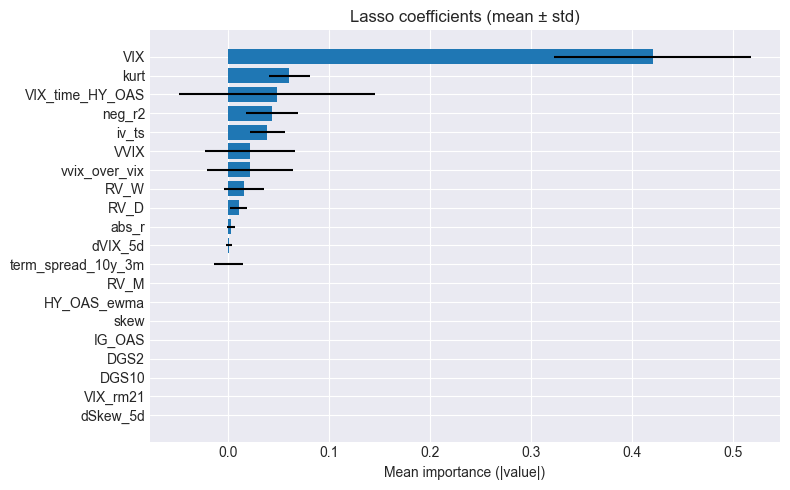

In [ ]:
ph.plot_mean_std_importance(
    lasso_summary,
    title="Lasso coefficients (mean ± std)",
    top_n=20,
    abs_values=True,
)

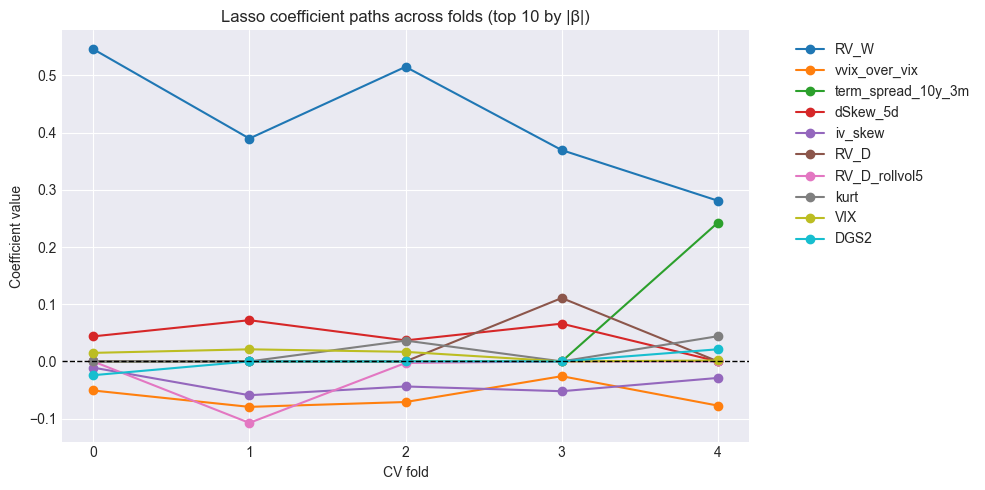

In [ ]:
ph.plot_lasso_coef_paths(lasso_coefs, lasso_summary["feature"])

- `VIX_time_HY_OAS` is a **regime-specific** candidate: it only becomes meaningful in the Covid / high-rate period and is strongly correlated with VIX (ρ ≈ 0.94). Thus, for the linear model we decide to drop it, as it introduces substitution effects.

- We keep the other features for now and assess their **out-of-sample** importance across folds.

In [ ]:
lasso_features = lasso_summary.loc[lasso_summary["mean"].abs() > 0.0, "feature"]
X_clean_lin = X_clean[lasso_features]
X_clean_lin = X_clean_lin.drop(["VIX_time_HY_OAS"], axis=1)

### Random Forest

We use the standard **Mean Decrease in Impurity (MDI)** importance computed per fold. Features with consistently negligible MDI are treated as **completely useless** and can be dropped from the RF feature set.

In [ ]:
rf_fi, rf_summary = in_sample_stability(X_clean, y_clean, rf, purged_cv)

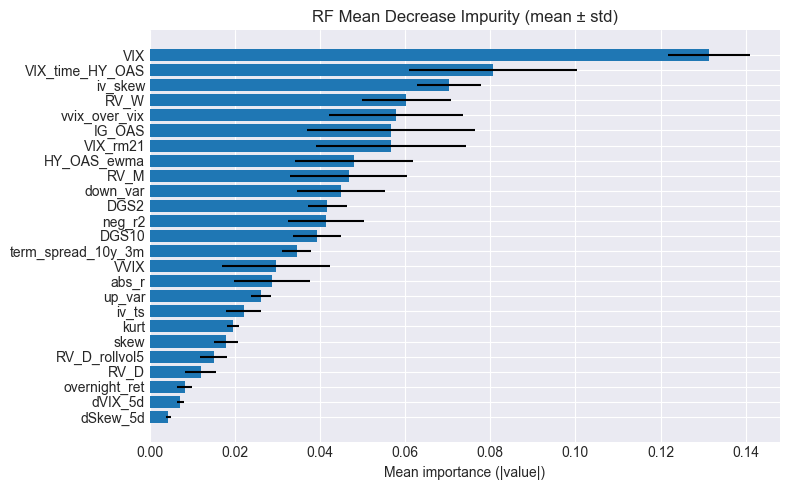

In [ ]:
ph.plot_mean_std_importance(
    rf_summary,
    title="RF Mean Decrease Impurity (mean ± std)",
    top_n=len(rf_summary),
    abs_values=True,
)

All features are selected in-sample because they reduce impurity, so they are **all explanatorily relevant**. We therefore keep the full set, including lower-importance variables like `dVIX` and `dSkew`, which may still matter in **stress regimes** when combined with other predictors.

## 8.3 Out-of-Sample Permutation Importance (Mean Decrease Accuracy)

We measure each feature’s **marginal OOS contribution**. For every CV split:

- 1. **Fit** the model on the training block,  
- 2. **Permute** one feature in the **validation** block,  
- 3. Record the **performance drop** (Δloss = permuted loss − baseline loss).

With correlated predictors, PI can **understate** a feature’s value (another correlated feature “covers” for it) and may discard variables that look useful in-sample. Therefore, interpret PI together with **In-model stability** and **Economic priors**.

### Linear Regression

In [ ]:
lasso_pi, lasso_pi_summary = oos_perm_importance(
    X_clean_lin, y_clean, lin_model, purged_cv, random_state=42
)

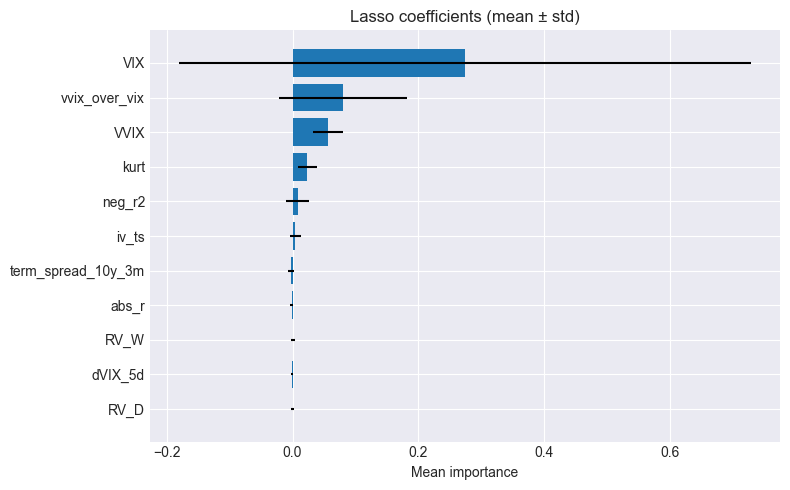

In [ ]:
ph.plot_mean_std_importance(
    lasso_pi_summary,
    title="Lasso coefficients (mean ± std)",
    top_n=20,
    abs_values=False,
)

- `log_kurtosis` is statistically active across folds and not highly correlated with other features, but its coefficient is **consistently negative**, which contradicts the intuition that high past kurtosis should signal higher future RV. Despite some predictive power, we treat it as a likely **statistical artefact** and exclude it from HAR-RV-X.

- `winsor_iv_ts` has **stable coefficients**, a **consistent negative sign** (economically reasonable for an inverted IV term structure), **moderate OOS importance**, and low correlation with other predictors, so we keep it as a candidate for HAR-RV-X.

- `sqrt_neg_r2` is also stable across folds, shows clear predictive power, and has a strong economic rationale (captures the **leverage effect**), so we include it in HAR-RV-X.

- Other features fail at least one of our criteria (unstable sign or near-zero coefficients, no clear OOS importance, or weak economic story) and are not retained in the parsimonious linear specification.

### Random Forest

In [ ]:
rf_pi, rf_pi_summary = oos_perm_importance(
    X_clean, y_clean, rf, purged_cv, random_state=42
)

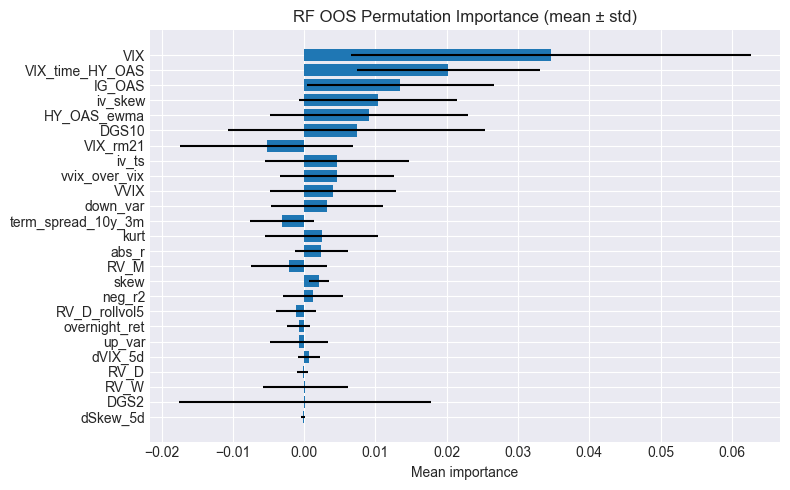

In [ ]:
ph.plot_mean_std_importance(
    rf_pi_summary,
    title="RF OOS Permutation Importance (mean ± std)",
    top_n=len(rf_pi_summary),
    abs_values=False
)

We prune a small set of clearly redundant / weak RF features that show no meaningful importance in or out-of-sample:

- `term_spread_10y_3m`: slight in-sample importance, no OOS signal, weak economic story  
- `VIX_rm21`: highly correlated with `RV_M` (ρ ≈ 0.92), no extra OOS signal  
- `DGS2`: unstable and insignificant OOS importance, no strong econ link to 21D RV  
- `RV_D_rollvol5`: no clear IS/OOS signal, strongly related to `RV_W`  
- `dSkew_5d`: unused IS/OOS (junk feature)  
- `overnight_ret`: no IS importance, small negative OOS contribution  
- `up_var`: dominated by `down_var` for leverage / downside effects

In [ ]:
features_to_drop = [
    "term_spread_10y_3m",
    "VIX_rm21",
    "DGS2",
    "up_var",
    "RV_D_rollvol5",
    "dSkew_5d",
    "overnight_ret",
]

X_clean_rf = X_clean.drop(columns=features_to_drop)
features_rf = X_clean_rf.columns
print(features_rf)

Index(['RV_D', 'RV_W', 'RV_M', 'abs_r', 'down_var', 'kurt', 'VIX', 'VVIX',
       'iv_skew', 'VIX_time_HY_OAS', 'iv_ts', 'dVIX_5d', 'neg_r2', 'DGS10',
       'IG_OAS', 'skew', 'HY_OAS_ewma', 'vvix_over_vix'],
      dtype='object')


# **9. Model Selection**

We now choose the **final fixed models** to carry into the truly out-of-sample walk-forward backtest. All comparisons use the same **Purged K-Fold** scheme and identical preprocessing for a fair, like-for-like evaluation.

We compare three layers:
- a **naive RV benchmark**,
- a family of **HAR-RV-X linear models**,
- a tuned **Random Forest** as a non-linear benchmark.

The main selection criterion is OOS CV performance (R² / MSE / QLIKE), with a **parsimony bias**: when models are statistically close, we prefer the **simpler** one (e.g. HAR-type over RF).

Finally, we compare the best linear and RF models and test simple linear ensembles to see whether combining them **improves accuracy and/or reduces error variance**. If ensembles do not add value, we retain the single best parsimonious model.

In [ ]:
data = pd.concat([X, y], axis=1)
data = data.dropna()

X_train = data[X.columns]
y_train = data[y.name]

purged_cv = PurgedKFold(
    n_splits=10,      # ≈ 1-year validation blocks
    purge_gap=21,   # 21-day RV horizon
    embargo=0.01,  # 1% embargo after validation fold
)

# Common data preprocessing config
dp_kwargs = dict(
    log_features=log_features,
    winsor_sqrt_features=winsor_sqrt_features,
    winsor_features=winsor_features
)

## 9.0 Baseline forecast (Naive RV)

As a minimal benchmark, we use a “no-model” forecast that simply carries the current
21-day realized volatility forward:

$$
\widehat{RV}^{(21)}_{t+21} = RV^{(21)}_t.
$$

This naive RV forecast is used as a benchmark to beat by the other
models and serves as a floor: any candidate specification that cannot beat this
baseline is not considered useful.

In [ ]:
y_pred_naive = np.log(X_train["RV_M"])

metrics_naive = compute_metrics(y_train, y_pred_naive)
metrics_naive = pd.DataFrame(
    [{"model": "Naive-RV", **metrics_naive}]
).set_index("model")

display(metrics_naive)

R2       MSE     QLIKE  Var_res  R2_oos
model                                                  
Naive-RV  0.254411  0.633659  0.325268  0.63386     0.0

## 9.1 Linear Models

We compare three nested HAR-type specifications:

1. **HAR-RV**  
   The classical benchmark that uses only realized volatility lags to forecast future RV.  
   This specification is well established in the volatility-forecasting literature.

2. **HAR-RV-VIX**  
   A natural extension that augments HAR-RV with a forward-looking volatility measure, the VIX.  
   Several studies document VIX as a strong predictor of 1-month realized volatility.

3. **HAR-RV-VIX-X**  
   A further extension where we add a small set of economically motivated predictors
   $X_t$ that show robust predictive power for forward RV.  
   In our case we consider:
   - **HAR-RV-VIX-L**: adding a leverage-effect proxy (downside returns),
   - **HAR-RV-VIX-IVTS**: adding the IV term-structure slope,
   - **HAR-RV-VIX-L-IVTS**: combining both leverage and IV term-structure features.

These HAR-RV-VIX-X variants remain parsimonious and interpretable, and serve as
our main linear benchmarks against richer machine-learning models.

In [ ]:
har_specs = {
    "HAR-RV":            ["RV_D", "RV_W", "RV_M"],
    "HAR-RV-VIX":        ["RV_D", "RV_W", "RV_M", "VIX"],
    "HAR-RV-VIX-L":      ["RV_D", "RV_W", "RV_M", "VIX", "neg_r2"],
    "HAR-RV-VIX-IVTS":   ["RV_D", "RV_W", "RV_M", "VIX", "iv_ts"],
    "HAR-RV-VIX-L-IVTS": ["RV_D", "RV_W", "RV_M", "VIX", "neg_r2", "iv_ts"],
}

dp_kwargs["scale"] = True # Need to scale

metrics_lin = []  # list of metrics dicts
y_preds_lin = {}  # name -> CV predictions (Series)

for name, feats in har_specs.items():
    metrics, y_pred = eval_model_cv(
        name=name,
        base_estimator=lin_model,
        features=feats,
        X=X_train,
        y=y_train,
        cv=purged_cv,
        dp_kwargs=dp_kwargs,
        y_pred_bench=y_pred_naive,
    )
    metrics_lin.append(metrics)
    y_preds_lin[name] = y_pred

metrics_lin = pd.DataFrame(metrics_lin).set_index("model")
display(pd.concat([metrics_naive, metrics_lin], axis=0))

R2       MSE     QLIKE   Var_res    R2_oos
model                                                              
Naive-RV           0.254411  0.633659  0.325268  0.633860  0.000000
HAR-RV             0.428283  0.485890  0.227163  0.486040  0.233201
HAR-RV-VIX         0.508466  0.417744  0.183540  0.417825  0.340744
HAR-RV-VIX-L       0.505366  0.420378  0.185880  0.420421  0.336587
HAR-RV-VIX-IVTS    0.510692  0.415852  0.184177  0.415904  0.343730
HAR-RV-VIX-L-IVTS  0.508016  0.418126  0.185668  0.418149  0.340141

The `HAR-RV-VIX-IVTS` specification yields the best **average** performance. However, it barely improves on `HAR-RV-VIX` despite adding one extra predictor. We therefore check whether it actually outperforms `HAR-RV-VIX` consistently across most folds.

Folds where HAR-RV-VIX-IVTS better: 6 / 10
Mean ΔMSE (B - A): -0.0018831446138953337


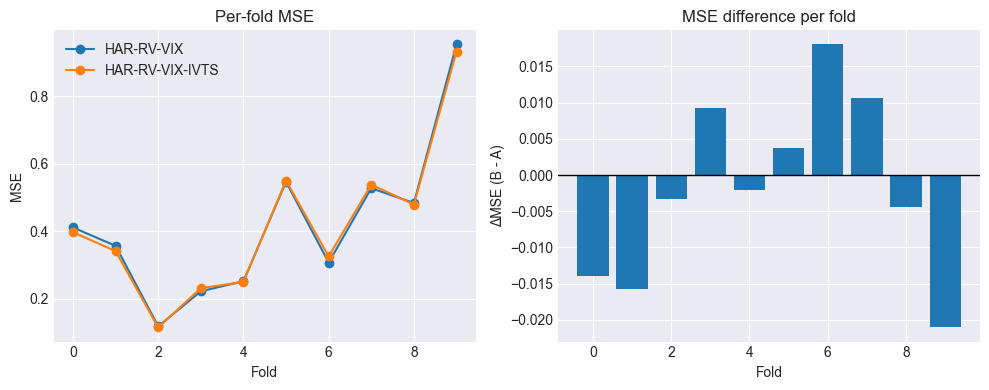

In [ ]:
lin_model = Pipeline([
    ("dp", DataProcessor(**dp_kwargs)),
    ("lr", LinearRegression()),
])

# HAR-RV-VIX
scores_vix = cross_val_score(
    lin_model,
    X_train[har_specs["HAR-RV-VIX"]],
    y_train,
    cv=purged_cv,
    scoring="neg_mean_squared_error",
)

# HAR-RV-VIX-IVTS
scores_vix_ivts = cross_val_score(
    lin_model,
    X_train[har_specs["HAR-RV-VIX-IVTS"]],
    y_train,
    cv=purged_cv,
    scoring="neg_mean_squared_error",
)

ph.plot_cv_mse_comparison(
    scores_vix,
    scores_vix_ivts,
    label_a="HAR-RV-VIX",
    label_b="HAR-RV-VIX-IVTS",
)

The `HAR-RV-VIX-IVTS` specification delivers the **highest average R²**, but only marginally so and without a clear, consistent gain across folds. In several folds it actually underperforms `HAR-RV-VIX`. Given this very small and unstable improvement for just one extra predictor, we retain `HAR-RV-VIX` as our preferred linear benchmark.

## **9.2 Random Forest**

For the non-linear side (Random Forest), we perform **hyperparameter tuning** on the key parameters (not too many to avoid overfitting the validation set) using the same Purged K-Fold CV, and keep the RF configuration with the best validation performance.

In [ ]:
param_grid = {
    "rf__max_depth": [3, 5, 7],
    "rf__min_samples_leaf": [3, 5, 10],
    "rf__max_features": ["sqrt", 0.5, 1.0],
}

dp_kwargs["scale"] = False # No need to scale

pipe_rf = Pipeline([
    ("dp", DataProcessor(**dp_kwargs)),
    ("rf", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
    )),
])

gscv = GridSearchCV(
    pipe_rf, param_grid=param_grid, 
    scoring="neg_mean_squared_error",
    cv=purged_cv, n_jobs=-1
)

X_train_rf = X_train[features_rf]
gscv.fit(X_train_rf, y_train)
print("Best params:", gscv.best_params_)

Best params: {'rf__max_depth': 5, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 10}


In [ ]:
# best RF pipeline from GridSearchCV (dp + rf)
best_rf_pipe = gscv.best_estimator_
best_rf = best_rf_pipe.named_steps["rf"] 

metrics_rf, y_pred_rf = eval_model_cv(
    name="Random Forest",
    base_estimator=best_rf,
    features=features_rf,
    X=X_train,
    y=y_train,
    cv=purged_cv,
    dp_kwargs=dp_kwargs,
    y_pred_bench=y_pred_naive,
)
metrics_rf = pd.DataFrame([metrics_rf]).set_index("model")

display(pd.concat([metrics_naive, metrics_rf], axis=0))

R2       MSE     QLIKE   Var_res    R2_oos
model                                                          
Naive-RV       0.254411  0.633659  0.325268  0.633860  0.000000
Random Forest  0.450147  0.467307  0.208689  0.467336  0.262526

## **9.3 Linear vs Random Forest + Ensembles**

Here we compare the forecasts of the best linear HAR-RV-VIX model and the tuned Random Forest, and test whether simple ensembles of the two can improve overall performance and/or reduce the variance of forecast errors.

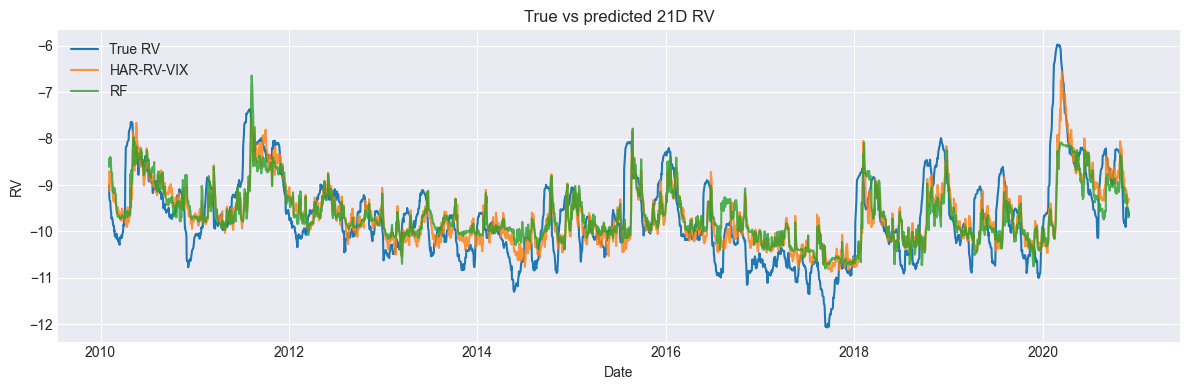

In [ ]:
ph.plot_model_comparison_ts(
    y_train,
    y_pred_1=y_preds_lin["HAR-RV-VIX"],
    y_pred_2=y_pred_rf,
    label_1="HAR-RV-VIX",
    label_2="RF",
)

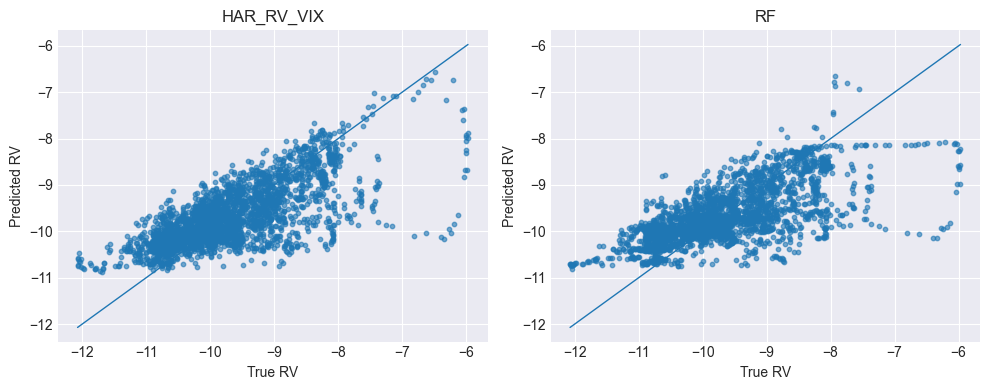

Correlation of predictions: 0.9405283454023914


In [ ]:
ph.plot_model_comparison_scatter(
    y_train,
    y_preds_lin["HAR-RV-VIX"], 
    y_pred_rf,
    label_1="HAR_RV_VIX",
    label_2="RF",
)

Here we see that **forecast errors grow when RV is high**, which is expected: extreme volatility regimes are inherently harder to predict accurately.

In [14]:
weights = [0.5, 0.7, 0.8]

ens_metrics, ens_preds = eval_ensembles(
    y_train,
    y_preds_lin["HAR-RV-VIX"],
    y_pred_rf,
    weights,
    y_pred_bench=y_pred_naive
)

display(pd.concat([metrics_lin.loc[["HAR-RV-VIX"]], metrics_rf, ens_metrics], axis=0))

NameError: name 'y_train' is not defined

### **Conclusion**

We do not find any strong evidence that an ensemble adds value here: it neither improves predictive performance nor reduces the variance of the forecast errors compared to the individual models.

We therefore keep `HAR-RV-VIX` as our final linear model specification.

# **10. Out-of-Sample Walk-Forward Evaluation**

In this section we evaluate the **final fixed model** (`HAR-RV-VIX`) on a held-out period using a true **walk-forward** scheme.
We compare its performance against two benchmarks:

- a **Naive RV** benchmark, to measure the **forecasting edge** of our model,
- a **HAR-RV** benchmark, to measure the added value of including VIX (an “econometric edge”).

## 10.1 Backtest Horizon & Data Construction

We evaluate performance over the period `2021-01-01` to `2025-12-31`.
To avoid any look-ahead, we build the feature/target panel using all
available data from the start of the research sample up to the end of
the backtest window.

In [ ]:
start_backtest = "2021-01-01"
end_backtest = "2025-12-31"

# From start of research (2010-01-01) to end of backtest (2025-12-31)
es_5min_full = load_intraday_prices(
    "data/intermediate/es-5m.csv",
    start=start,
    end=end_backtest,
)

X_full, y_full = rvfeat.build_har_vix_dataset(
    es_5min_full,
    h=21,
)
X_full

## 10.2 Walk-Forward Configuration

We use a **rolling 3-year window**, re-fitting the model **monthly**:

- training window: last 3 years of data up to the rebalancing date,
- test window: next month,
- we **purge** the last 21 days of the training window, because the
  21-day forward target at time *t* uses information up to *t+21*.

As before, all preprocessing (log/sqrt transforms, winsorisation, scaling)
is learned **only on the training window** and then applied to the
corresponding test window inside the pipeline.

In [ ]:
# 1) Define model (HAR-RV-VIX with scaling)
dp_kwargs["scale"] = True

lin_pipe = Pipeline([
    ("dp", DataProcessor(**dp_kwargs)),
    ("lr", LinearRegression()),
])

wf = WalkForwardOOS(
    estimator=lin_pipe,
    start_backtest=start_backtest,
    end_backtest=end_backtest,
    expanding=False,   # rolling window
    window_years=3,
    rebal_freq="ME",   # month-end
    purge_horizon=21,
)

## 10.3 Walk-Forward Results & Performance Metrics

We now run the walk-forward procedure over the 2021–2025 backtest window and collect the **true vs predicted** 21-day log-RV for each model. On this OOS path we compare the **Naive-RV**, **HAR-RV**, and **HAR-RV-VIX** using the same metrics as in the research section (R², MSE, QLIKE, residual variance). This tells us whether the gains we saw in cross-validation actually **translate into genuine forecasting edge** on unseen data.

In [ ]:
#HAR-RV-VIX (our best model)
preds_rv_vix = wf.run(X_full, y_full)

# HAR-RV as a second benchmark (same WF config)
preds_rv = wf.run(X_full.drop(columns=["VIX"]), y_full)

# 3) Extract OOS predictions
y_true_vix = preds_rv_vix["y_true"]
y_pred_vix = preds_rv_vix["y_pred"]

y_true_har = preds_rv["y_true"]
y_pred_har = preds_rv["y_pred"]

y_true = y_true_vix

# 4) Naive benchmark on the same OOS dates
y_pred_naive = np.log(X_full.loc[y_true.index, "RV_M"])

# 5) Compute metrics
metrics_naive = compute_metrics(y_true, y_pred_naive)
metrics_har = compute_metrics(y_true, y_pred_har, y_pred_bench=y_pred_naive)
metrics_vix = compute_metrics(y_true, y_pred_vix)

metrics_naive["model"] = "Naive_RV"
metrics_har["model"] = "HAR-RV"
metrics_vix["model"] = "HAR-RV-VIX"

metrics_df = pd.DataFrame([metrics_naive, metrics_har, metrics_vix]).set_index("model")
display(metrics_df)

R2       MSE     QLIKE    R2_oos
model                                             
Naive_RV    0.094304  0.507837  0.279067  0.000000
HAR-RV      0.291954  0.397012  0.208633  0.218230
HAR-RV-VIX  0.367568  0.354613  0.178821  0.301718

## 10.4 Diagnostic plots 

### Naive RV vs HAR-RV-VIX

In [13]:
plt.figure(figsize=(12, 4))

y_true.plot(label="True 21D RV", lw=1.5)
y_pred_naive.plot(label="Naive RV", lw=1)
y_pred_har.plot(label="HAR-RV", lw=1)
y_pred_vix.plot(label="HAR-RV-VIX", lw=1.5)

plt.legend()
plt.title("OOS forecasts: True vs Naive, HAR-RV, HAR-RV-VIX")
plt.ylabel("log 21D RV")
plt.tight_layout()
plt.show()

NameError: name 'y_true' is not defined

<Figure size 1200x400 with 0 Axes>

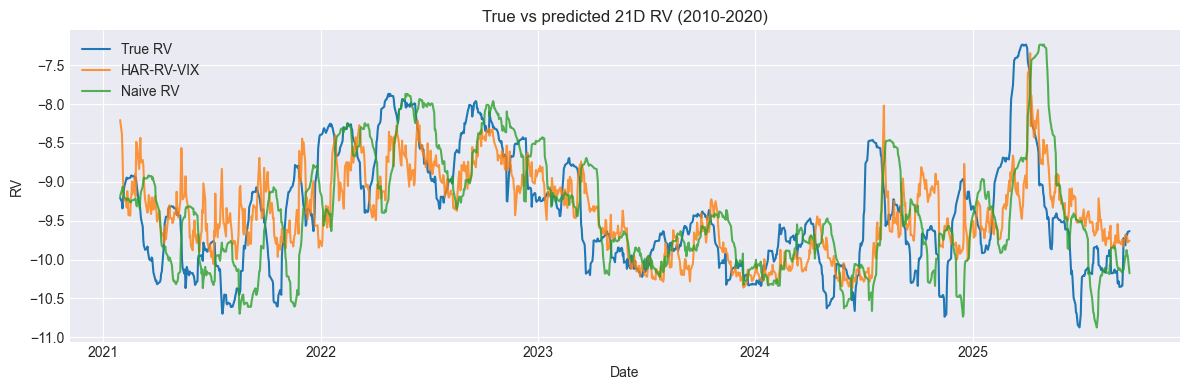

In [ ]:
ph.plot_model_comparison_ts(
    y_true,
    y_pred_1=y_pred_vix,   
    y_pred_2=y_pred_naive,
    label_1="HAR-RV-VIX",
    label_2="Naive RV",
)

### HAR-RV vs HAR-RV-VIX

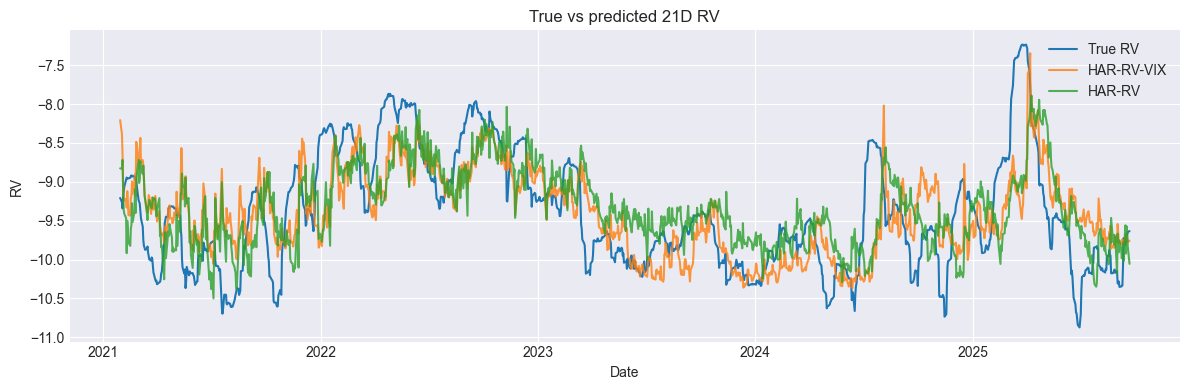

In [ ]:
ph.plot_model_comparison_ts(
    y_true,
    y_pred_1=y_pred_vix,  
    y_pred_2=y_pred_har,
    label_1="HAR-RV-VIX",
    label_2="HAR-RV",
)

The $R2_{oos}$ for `HAR-RV-VIX`beats the two benchmark models, thus proving a true forecasting edge over the naive RV as well as an econometrics edge over the standard HAR-RV model.

Please note that all decisions where made on the reserach set from `2010` to `2020` and that we have run the bakctets only once in order to avoid any selection bias by the tweak of the backtest parameters (such as the rebalancing or the size of the rolling window)

# Conclusion

We have proved how difficult it is to beat the HAR-RV model and that non-linear RF models did not show any usefulness in capturing complex patterns. Maybe for another horizon forecast the conclusions would be different and some predictors might be more useful at a shorter horizon than 21 days, but for the purpose of our options trading strategies we needed to match the horizon forecast with the DTE of the option contratc we aim to trade, namely 30 DTE optiosn whihc show the highets liquidity.